In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

import mlflow

from matplotlib.patches import Patch

from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error, PredictionErrorDisplay
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, MultiLabelBinarizer, OneHotEncoder, PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA, KernelPCA


In [5]:
import sys

# print(sys.executable)
print(sys.version)

3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:29:11) [MSC v.1935 64 bit (AMD64)]


# Weather Forecast
### Experiments

##### _Helper functions_

In [6]:
def create_lags(dataframe, column_list, n_lags):
    """
    Creates lags for the specified columns.
    Returns pandas DataFrame.
    """
    # TODO: check datetime order and missing days
    
    if type(column_list) == str:
        column_list = [column_list]

    lags = range(1, n_lags + 1)

    lags_dataframe = dataframe[column_list].shift(lags)

    assert dataframe.shape[0] == lags_dataframe.shape[0]

    return lags_dataframe

In [7]:
def plot_residuals(y_true, y_pred, feature):
    
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    
    PredictionErrorDisplay.from_predictions(
        y_true,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=axs[0]
    )
    axs[0].set_title("Actual vs. Predicted values")
    
    PredictionErrorDisplay.from_predictions(
        y_true,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        ax=axs[1]
    )
    axs[1].set_title("Residuals vs. Predicted Values")
    
    fig.suptitle(feature)
    plt.tight_layout()
    plt.show()

In [8]:
def plot_residuals_vs_time(y_actual, y_predicted, feature, dataframe):
    plt.figure(figsize=(12, 6))
    
    plt.scatter(dataframe.datetime[y_actual.index], y_predicted - y_actual)

    for year in dataframe.datetime.dt.year.unique(): 
        plt.axvline(pd.Timestamp(year, 1, 1), c = "lightgrey", ls = "--")
    
    plt.title(f"{feature} - Residuals vs. Datetime")
    plt.show()

In [9]:
def plot_cv_indices(cv, X, ax, fig, n_splits, lw=10):
    """
    Create a sample plot for indices of a cross-validation object.
    Function copied (with few adjustments) from sklearn documentation at
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
    """

    cmap_cv = plt.cm.summer
    cmap_year = plt.cm.viridis
    cmap_precip = plt.cm.Blues
    cmap_temp = plt.cm.coolwarm
    cmap_cloudcover = plt.cm.Grays

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=X.temp, groups=X.dt_year)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data targets and years at the end    
    temp_scatter = ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=X.temp, marker="_", lw=lw, cmap=cmap_temp, label = "temp"
    )

    precip_scatter = ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=X.precip, marker="_", lw=lw, cmap=cmap_precip
    )

    cloudcover_scatter = ax.scatter(
        range(len(X)), [ii + 3.5] * len(X), c=X.cloudcover, marker="_", lw=lw, cmap=cmap_cloudcover
    )

    year_scatter = ax.scatter(
        range(len(X)), [ii + 4.5] * len(X), c=X.dt_year, marker="_", lw=lw, cmap=cmap_year
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["temp", "precip", "cloudcover", "year"]
    ax.set(
        yticks=np.arange(n_splits + 4) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index (days)",
        ylabel="CV iteration",
        ylim=[n_splits + 4.2, -0.2],
        xlim=[0, 1000],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)

    
    # Add colorbars
   
    plt.colorbar(temp_scatter, cax = fig.add_axes([0.95, 0.5, 0.3, 0.02]), orientation="horizontal").set_label(label = "Temperature [C$\degree$]", size=8)
    plt.colorbar(precip_scatter, cax = fig.add_axes([0.95, 0.35, 0.3, 0.02]), orientation="horizontal").set_label(label="Precipitation [mm]", size=8)
    plt.colorbar(cloudcover_scatter, cax = fig.add_axes([0.95, 0.2, 0.3, 0.02]), orientation="horizontal").set_label(label="Cloud Cover [%]", size=8)
    
    ax.legend(
        [Patch(color=cmap_cv(0.02)), Patch(color=cmap_cv(0.8)),
         Patch(color=cmap_year(0.02)), Patch(color=cmap_year(0.5)),Patch(color=cmap_year(0.98))],
        ["Training set", "Validation set", "2021", "2022", "2023"],
        loc=(1.02, 0.7),
    )
    
    return ax

In [10]:
def plot_score_cv(cv_results, target = "temp", score_metrics = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"), skip_folds = 0):
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 6), constrained_layout = True)
    fig.suptitle(f"Cross Validation Scores, Target: {target}")

    
    n_folds = len(cv_results["test_r2"])
    fold_indices = np.arange(n_folds)


    for metric, ax in zip(score_metrics, axs.flat):
        
        ax.plot(fold_indices[skip_folds:], cv_results[f"train_{metric}"][skip_folds:], label = "train")
        ax.plot(fold_indices[skip_folds:], cv_results[f"test_{metric}"][skip_folds:], label = "validation")

        ax.set_xlabel("Fold index")
        ax.set_xticks(fold_indices)
        ax.set_ylabel(metric)
        ax.legend()
    
    plt.show()

In [11]:
def plot_cv_predictions(cv_results, input_dataframe, target_column, n_fold = -1):
    plt.figure(figsize=(13, 4))

    
    estimator = cv_results["estimator"][n_fold]
    
    plt.plot(input_dataframe.datetime, input_dataframe[target_column], c = "lime", lw = 1, label = "actual values") # y_true
    
    indices_train = cv_results["indices"]["train"][n_fold]
    predictions_train = estimator.predict(input_dataframe.loc[indices_train])
    plt.plot(input_dataframe.datetime.loc[indices_train], predictions_train, lw = 1, label = "predictions train set")

    indices_test = cv_results["indices"]["test"][n_fold]
    predictions_test = estimator.predict(input_dataframe.loc[indices_test])
    plt.plot(input_dataframe.datetime.loc[indices_test], predictions_test, lw = 1, label = "predictions validation set")

    plt.title(f"Predictions of Model trained on Fold {n_fold}")
    plt.ylabel(target_column)
    plt.legend()

    plt.show()


In [12]:
def run_cv_experiment(
        estimator, 
        X, 
        y, 
        cv, # instance of TimeSiresSplit or KFold
        scoring_metrics = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"), 
        log_experiment = False, 
        experiment_name = "", 
        target_name = ""
        ):

    assert isinstance(cv, TimeSeriesSplit), "cv must be an instance of TimeSeriesSplit, no index sequence allowed"
    
    cv_results = cross_validate(
        estimator, # Estimator
        X, # X
        y, # y
        scoring = scoring_metrics, 
        cv = cv, 
        return_train_score = True, 
        return_indices = True,
        return_estimator = True
        )

    if log_experiment is False:
        return cv_results

    feature_names = None
    feature_count = 0
    try:
        feature_names = estimator[-2].get_feature_names_out()
        feature_count = len(feature_names)
        feature_names = [feat for feat in estimator[-2].get_feature_names_out() if ("_lag_2" in feat or "dt_" in feat)]
    except(AttributeError):
        feature_names = "Estimator does not provide get_feature_names_out"
    
    experiment = mlflow.create_experiment(name = f"{experiment_name}_{feature_count}_features_{target_name}")
    
    n_folds = cv.n_splits
    
    for run_idx in range(n_folds):
        with mlflow.start_run(experiment_id = experiment, run_name=f"fold_{run_idx}"):
            
            mlflow.log_param("cv_n_folds", n_folds)
            mlflow.log_param("cv_type", cv.__class__.__name__)
            mlflow.log_param("target", target_name)
            mlflow.log_param("n_samples_train", len(cv_results["indices"]["train"][run_idx]))
            mlflow.log_param("n_samples_test", len(cv_results["indices"]["test"][run_idx]))
            mlflow.log_param("feature_names", feature_names)
            mlflow.log_param("feature_count", feature_count)
            
    
            for metric in scoring_metrics:
                test_metric_key = f"test_{metric}"
                train_metric_key = f"train_{metric}"
                mlflow.log_metric(test_metric_key, cv_results[test_metric_key][run_idx])
                mlflow.log_metric(train_metric_key, cv_results[train_metric_key][run_idx])

    return cv_results


In [390]:
def run_grid_search(
        estimator,
        X,
        y,
        param_grid,
        cv,
        scoring_metrics = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"),
        run_name = "", 
        target = "temp",
        pca_kernel = "",
        log_run = False,
        experiment = "372952805905307120"):
    
    grid_search = GridSearchCV(
    estimator, 
    param_grid = param_grid,
    cv = cv,
    scoring = scoring_metrics,
    refit = "r2", # choose best model based on r2
    return_train_score = True
    )

    grid_search.fit(X, y)

    result = grid_search.cv_results_

    gridsearch_results_df = pd.DataFrame(result)

    if log_run is False:
        
        return(grid_search, gridsearch_results_df)
    
    
    with mlflow.start_run(experiment_id = experiment, run_name = run_name) as run:
        mlflow.log_param("target", target)
        mlflow.log_param("pca_kernel", pca_kernel)
        mlflow.log_params(param_grid)

        file = f"output_gridsearch/gridsearch_{target}_{run_name}"
        gridsearch_results_df.to_csv(file, index=False)
        mlflow.log_artifact(file)
        mlflow.log_params({f"best_{key}": value for key, value in grid_search.best_params_.items()})  
        
        return(grid_search, gridsearch_results_df)

In [14]:
def filter_grid_search_df(dataframe, metric = "r2", n_best = 5):
        
        # "r2": "r2",
        # "mse": "neg_mean_squared_error",
        # "mae": "neg_mean_absolute_error",
        # "max": "max_error"

    metric_df = dataframe[make_column_selector(pattern = f"param_|{metric}")]
    
    return metric_df[metric_df[f"rank_test_{metric}"] <= n_best].T

## 3. Experiments

We read our train set - the same dataset we explored in the previous notebook.

In [19]:
file_path = "data/Sofia 2021-01-01 to 2023-09-26.csv"

In [20]:
weather_data_raw = pd.read_csv(file_path)
weather_data_raw.head(2)

name    datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0  Sofia  2021-01-01     11.1     -0.9   3.9          11.1          -1.4   
1  Sofia  2021-01-02      9.1     -3.9   1.6           7.9          -5.1   

   feelslike  dew  humidity  ...  solarenergy  uvindex  severerisk  \
0        3.1  0.1      78.2  ...          NaN      NaN         NaN   
1        0.7 -2.0      78.8  ...          NaN      NaN         NaN   

               sunrise               sunset  moonphase  \
0  2021-01-01T07:57:10  2021-01-01T17:03:43       0.58   
1  2021-01-02T07:57:14  2021-01-02T17:04:36       0.62   

                     conditions  \
0  Snow, Rain, Partially cloudy   
1                         Clear   

                                         description       icon     stations  
0  Partly cloudy throughout the day with morning ...       rain  15614099999  
1               Clear conditions throughout the day.  clear-day  15614099999  

[2 rows x 33 columns]

In [21]:
weather_data_raw.shape

(999, 33)

In [22]:
weather_data_raw.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [23]:
weather_data = weather_data_raw.copy()
weather_data.datetime = pd.to_datetime(weather_data.datetime)
weather_data.head()

name   datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0  Sofia 2021-01-01     11.1     -0.9   3.9          11.1          -1.4   
1  Sofia 2021-01-02      9.1     -3.9   1.6           7.9          -5.1   
2  Sofia 2021-01-03     10.1      2.1   5.8          10.1          -1.1   
3  Sofia 2021-01-04      9.1      5.1   6.8           7.6           3.3   
4  Sofia 2021-01-05     11.1      2.1   6.8          11.1           0.6   

   feelslike  dew  humidity  ...  solarenergy  uvindex  severerisk  \
0        3.1  0.1      78.2  ...          NaN      NaN         NaN   
1        0.7 -2.0      78.8  ...          NaN      NaN         NaN   
2        4.4  3.5      86.0  ...          NaN      NaN         NaN   
3        5.6  5.4      90.8  ...          NaN      NaN         NaN   
4        5.7  2.3      75.2  ...          NaN      NaN         NaN   

               sunrise               sunset  moonphase  \
0  2021-01-01T07:57:10  2021-01-01T17:03:43       0.58   
1  2021-01-02T07:57:14  2021-01-02T17:04:36       0.62   
2  2021-01-03T07:57:15  2021-01-03T17:05:31       0.65   
3  2021-01-04T07:57:13  2021-01-04T17:06:28       0.69   
4  2021-01-05T07:57:09  2021-01-05T17:07:26       0.72   

                     conditions  \
0  Snow, Rain, Partially cloudy   
1                         Clear   
2        Rain, Partially cloudy   
3                Rain, Overcast   
4        Rain, Partially cloudy   

                                         description       icon     stations  
0  Partly cloudy throughout the day with morning ...       rain  15614099999  
1               Clear conditions throughout the day.  clear-day  15614099999  
2  Partly cloudy throughout the day with rain in ...       rain  15614099999  
3         Cloudy skies throughout the day with rain.       rain  15614099999  
4  Partly cloudy throughout the day with early mo...       rain  15614099999  

[5 rows x 33 columns]

### 3.1. Naive Forcating

Naive forecasting is one of the simplest time series forecasting techniques. The basic idea behind it is to assume that the future values of a time series will be the same as the last observed value. In other words, it assumes that there will be no change from the current state. This method exploits recency bias - assuming the most recent values are best predictors of the current value. Naive forecasting is almost always oversimplification of the problem, but is good for imputation in models with many exogenous features, or as base for comparing with more complex models.

Naive model would be:

$$ \tilde{y}_{(t)} = y_{(t - 1)} \textnormal {, where} $$
$$ \tilde{y}_{(t)} \textnormal { is the predicted value at time t } $$
$$ y_{(t - 1)} \textnormal { is the observed value at time t -1 (previous day)} $$

We make 3 separate naive models for average temperature, precipitation and cloud cover. `lag_1` are the previous values of the corresponding variable. Since there are no missing values in these features, as well as in the `datetime` column (saw that in the EDA), we obtain previous day value by simply shifting original values by one row:

In [24]:
weather_data_naive = weather_data[["datetime", "temp", "precip", "cloudcover"]]
weather_data_naive.isna().sum()

datetime      0
temp          0
precip        2
cloudcover    1
dtype: int64

In [25]:
weather_data_naive = weather_data_naive.fillna(0)

In [26]:
lags = create_lags(weather_data_naive, ["temp", "precip", "cloudcover"], 1)

In [27]:
weather_data_naive = pd.concat([weather_data_naive, lags], axis = 1)
weather_data_naive

datetime  temp  precip  cloudcover  temp_1  precip_1  cloudcover_1
0   2021-01-01   3.9     1.8        32.4     NaN       NaN           NaN
1   2021-01-02   1.6     0.0         8.3     3.9       1.8          32.4
2   2021-01-03   5.8     0.3        75.2     1.6       0.0           8.3
3   2021-01-04   6.8     4.0        96.3     5.8       0.3          75.2
4   2021-01-05   6.8     3.0        78.1     6.8       4.0          96.3
..         ...   ...     ...         ...     ...       ...           ...
994 2023-09-22  21.9     0.5        42.8    19.8       0.0          46.8
995 2023-09-23  23.1     0.0        21.4    21.9       0.5          42.8
996 2023-09-24  21.5     5.0        38.8    23.1       0.0          21.4
997 2023-09-25  20.2     0.0        55.2    21.5       5.0          38.8
998 2023-09-26  19.0     0.0        51.0    20.2       0.0          55.2

[999 rows x 7 columns]

Since there is no learning involved - our naive model is just simple mapping, we skip splitting into train and validation set and score on the whole dataset. Test set is however not included here, this is discussed later in this work. _Actual_ values $y$ are the values from the original columns, and _predicted_ $\tilde{y}$ are the lags. We drop the first row, because of the NaNs created from the shift and score. First we make sure there is only one NaN in each of the lag columns and drop them: 



In [29]:
weather_data_naive.isna().sum()

datetime        0
temp            0
precip          0
cloudcover      0
temp_1          1
precip_1        1
cloudcover_1    1
dtype: int64

In [30]:
weather_data_naive = weather_data_naive.dropna()
weather_data_naive

datetime  temp  precip  cloudcover  temp_1  precip_1  cloudcover_1
1   2021-01-02   1.6     0.0         8.3     3.9       1.8          32.4
2   2021-01-03   5.8     0.3        75.2     1.6       0.0           8.3
3   2021-01-04   6.8     4.0        96.3     5.8       0.3          75.2
4   2021-01-05   6.8     3.0        78.1     6.8       4.0          96.3
5   2021-01-06   5.1     0.0        60.5     6.8       3.0          78.1
..         ...   ...     ...         ...     ...       ...           ...
994 2023-09-22  21.9     0.5        42.8    19.8       0.0          46.8
995 2023-09-23  23.1     0.0        21.4    21.9       0.5          42.8
996 2023-09-24  21.5     5.0        38.8    23.1       0.0          21.4
997 2023-09-25  20.2     0.0        55.2    21.5       5.0          38.8
998 2023-09-26  19.0     0.0        51.0    20.2       0.0          55.2

[998 rows x 7 columns]

In [31]:
temp_actual = weather_data_naive.temp
temp_predicted = weather_data_naive.temp_1

In [32]:
r2_score(temp_actual, temp_predicted)

0.930667017395547

In [33]:
mean_squared_error(temp_actual, temp_predicted)

4.897765531062125

In [34]:
mean_absolute_error(temp_actual, temp_predicted)

1.607114228456914

The results seem unreasonably good. Since we have not scaled our data, the unit of Mean absolute error is the same as the original unit of the variable. MAE under 2 degrees C sounds great - why would we even need a more complex model? Wait this is __mean__, let's see the maximum error:

In [35]:
max_error(temp_actual, temp_predicted)

14.3

Error of 14 degrees is not acceptable. So initial scoring was not enough to evaluate the model. Let's examine residual plot:

In [36]:
# temp_actual

In [37]:
# def plot_residuals(y, y_pred):
#     plt.scatter(y, y_pred - y)

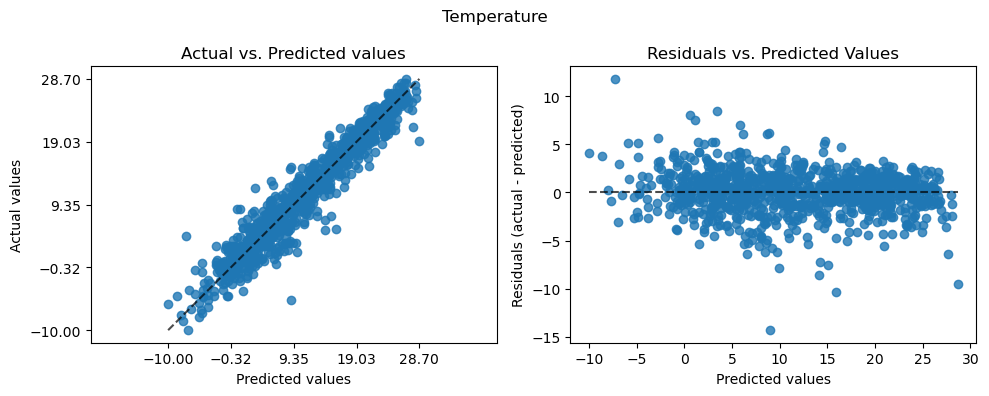

In [38]:
plot_residuals(temp_actual, temp_predicted, "Temperature")

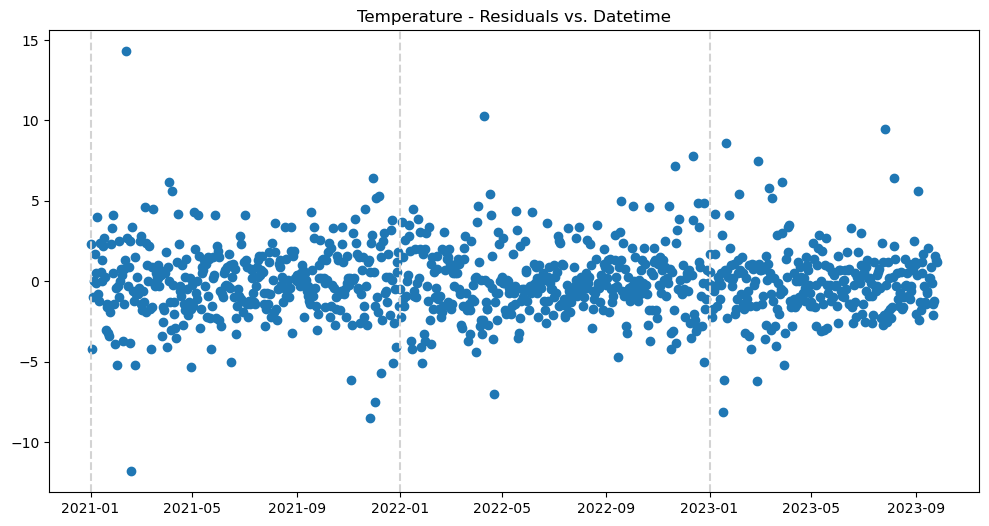

In [39]:
plot_residuals_vs_time(temp_actual, temp_predicted, "Temperature", weather_data_naive)

Let's see the scoring of precipitation and cloudcover:

In [40]:
precip_actual = weather_data_naive.precip
precip_predicted = weather_data_naive.precip_1

In [41]:
r2_score(precip_actual, precip_predicted)

-0.5453311677961608

In [42]:
mean_squared_error(precip_actual, precip_predicted)

36.766593186372745

In [43]:
mean_absolute_error(precip_actual, precip_predicted)

2.4585170340681364

In [44]:
max_error(precip_actual, precip_predicted)

58.0

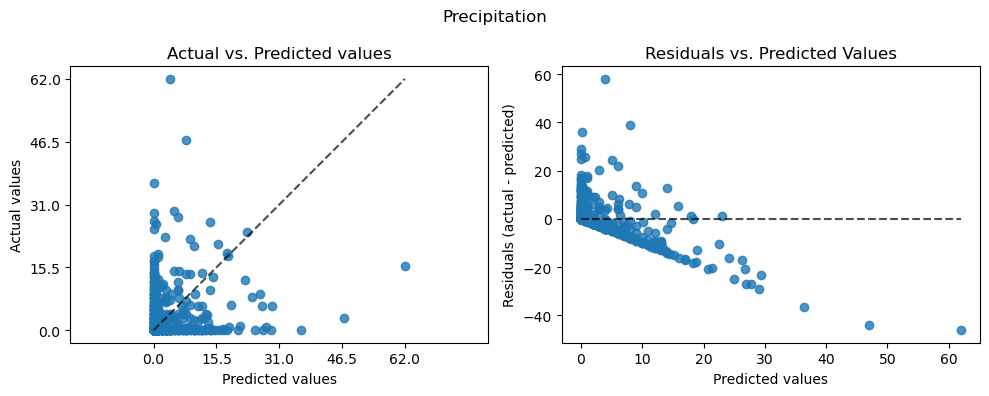

In [45]:
plot_residuals(precip_actual, precip_predicted, "Precipitation")

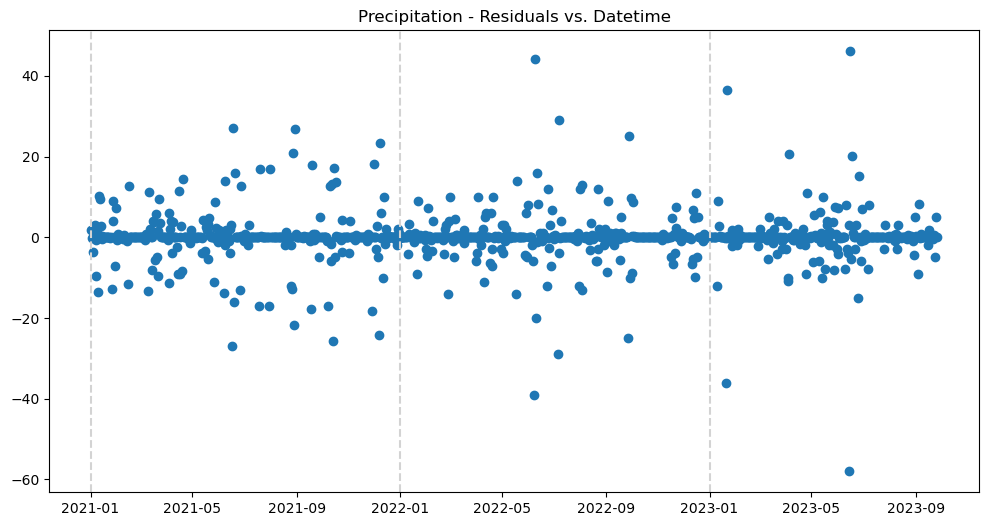

In [46]:
plot_residuals_vs_time(precip_actual, precip_predicted, "Precipitation", weather_data_naive)

In [47]:
cloudcover_actual = weather_data_naive.cloudcover
cloudcover_predicted = weather_data_naive.cloudcover_1

In [48]:
r2_score(cloudcover_actual, cloudcover_predicted)

0.29711056246819445

In [49]:
mean_absolute_error(cloudcover_actual, cloudcover_predicted)

17.053507014028057

In [50]:
max_error(cloudcover_actual, cloudcover_predicted)

79.2

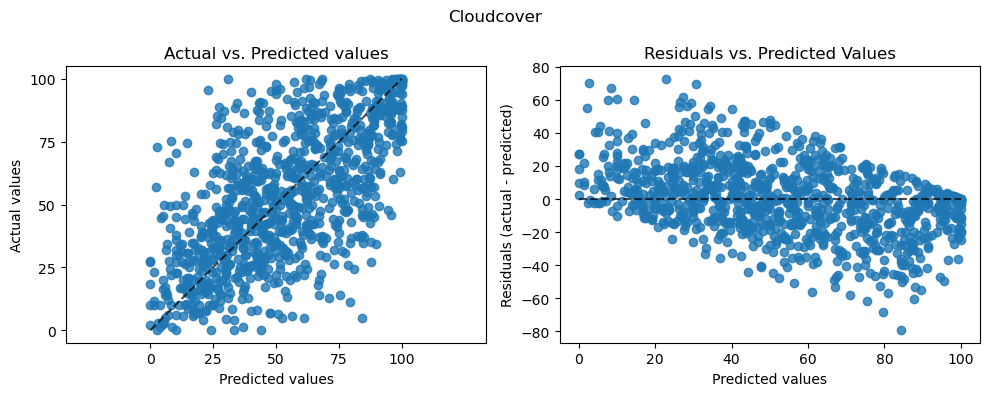

In [51]:
plot_residuals(cloudcover_actual, cloudcover_predicted, "Cloudcover")

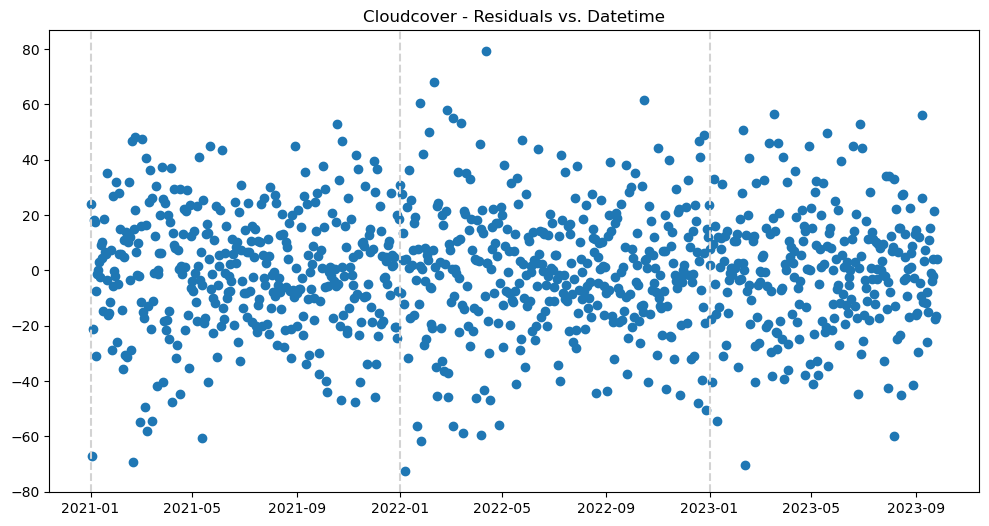

In [52]:
plot_residuals_vs_time(cloudcover_actual, cloudcover_predicted, "Cloudcover", weather_data_naive)

Terrible results for precipitation and cloud cover, as expected. This is forecasting for only 1 day ahead. As most of our values are daily average, we can predict a day's values after the previous has ended, which basically means today we predict for today - not useful at all. But the bad results make trying to forecast 2 or more days ahead obsolete. We need to make more complex model.

### 3.2. Autoregression

Autoregression is a time series forecasting model that uses observations from previous time steps as input to predict the value at one or several time steps ahead. In other words, it predicts the future values of a time series based on its own past values. In sklearn the way to add information from past observations (other rows) is to directly add them as features to the current observation, each new feature being the value at $n$ time steps back.  


![autoregression](https://cienciadedatos.net/images/transform_timeseries.gif)

+ _Time series transformation into a matrix of 5 lags and a vector with the value of the series that follows each row of the matrix._
[[source]](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

This approach allows us to also add exogenous variables - ones that are not time-related. In a weather forecasting model exogenous variables would be mostly location-related - latitude, altitude, terrain and proximity to large bodies of water. Since we will be forecasting for a single location all those features are ignored in our work.

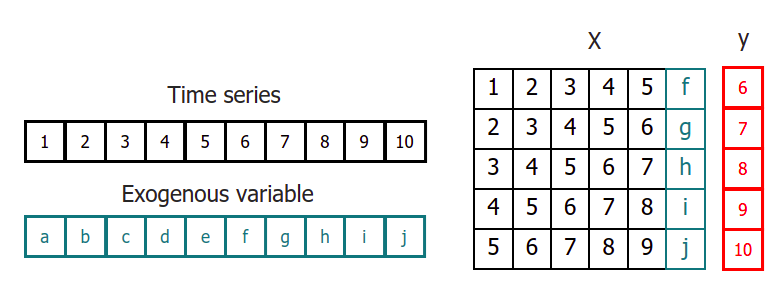

+ _Time series transformation including an exogenous variable._
[[source]](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

All of our variables are endogenous - they are both function of time and influence each others' future values. This means our task is actually __Vector Autoregression__ - a fancy way of saying that each of the original features is also a target. Usually temperature, humidity, precipitation, air pressure, wind speed, and wind direction are the main components of describing and forecasting weather conditions, but for simplicity our base features and targets will be temperature, precipitation and cloudcover, although we will use other features in the more complex models. Lags chosen are 1 to 10, meaning we will have past 10 days as input and predict the current day - that is __single step forecasting__. This may not be very useful in real life, but is enough to evaluate and compare models, __recursive multi-step forecasting__ will be tried only with our final model. That means, that we should keep in mind that all metrics will be somewhat better than the final performance.

For autoregressive models we have chosen Linear Regression for estimator in order to easily compare progressively more complex models. Assumption is they would severely underfit the data and not need regularisation anyway.



In [53]:
n_lags = 10
base_features = ["temp", "precip", "cloudcover"]
features_with_lag = [
    "tempmax", "tempmin", "temp", 
    "dew", "humidity", 
    "precip", "precipprob", "precipcover", "preciptype", 
    "snow", "snowdepth", 
    "windgust", "windspeed", "winddir", 
    "sealevelpressure", 
    "cloudcover", "visibility", 
    "conditions", "description", "icon"
]

In [54]:
# little cheat, impute with constant before lags
weather_data.preciptype = weather_data.preciptype.fillna("no_precip")

In [55]:
lags_df = create_lags(weather_data, features_with_lag, n_lags)
# lags_df

In [56]:
weather_data_with_lags_raw = pd.concat([weather_data, lags_df], axis = 1)
weather_data_with_lags_raw.head(3)

name   datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0  Sofia 2021-01-01     11.1     -0.9   3.9          11.1          -1.4   
1  Sofia 2021-01-02      9.1     -3.9   1.6           7.9          -5.1   
2  Sofia 2021-01-03     10.1      2.1   5.8          10.1          -1.1   

   feelslike  dew  humidity  ...  snowdepth_10  windgust_10  windspeed_10  \
0        3.1  0.1      78.2  ...           NaN          NaN           NaN   
1        0.7 -2.0      78.8  ...           NaN          NaN           NaN   
2        4.4  3.5      86.0  ...           NaN          NaN           NaN   

  winddir_10  sealevelpressure_10  cloudcover_10  visibility_10  \
0        NaN                  NaN            NaN            NaN   
1        NaN                  NaN            NaN            NaN   
2        NaN                  NaN            NaN            NaN   

   conditions_10  description_10  icon_10  
0           None            None     None  
1           None            None     None  
2           None            None     None  

[3 rows x 233 columns]

In [57]:
weather_data_with_lags_raw.shape

(999, 233)

We drop first 10 rows - the ones with missing values in the lags:

In [58]:
weather_data_with_lags = weather_data_with_lags_raw.drop(range(n_lags))

In [59]:
weather_data_with_lags = weather_data_with_lags.reset_index()

In [60]:
weather_data_with_lags["dt_year"] = weather_data_with_lags.datetime.dt.year # for visualisation of cv split

In [61]:
weather_data_with_lags.shape

(989, 235)

In [62]:
weather_data_with_lags.head(3)

index   name   datetime  tempmax  tempmin  temp  feelslikemax  \
0     10  Sofia 2021-01-11      5.1      1.1   2.7           3.4   
1     11  Sofia 2021-01-12      1.1     -0.9   0.3           1.1   
2     12  Sofia 2021-01-13      1.2     -1.3  -0.3          -0.9   

   feelslikemin  feelslike  dew  ...  windgust_10  windspeed_10  winddir_10  \
0          -2.1        0.3  1.8  ...          NaN          16.6       232.9   
1          -6.8       -2.0 -0.4  ...          NaN          16.6       111.8   
2          -7.0       -4.7 -3.0  ...          NaN          20.5       120.0   

   sealevelpressure_10 cloudcover_10  visibility_10  \
0               1014.9          32.4           12.3   
1               1021.1           8.3           12.4   
2               1018.3          75.2           11.3   

                  conditions_10  \
0  Snow, Rain, Partially cloudy   
1                         Clear   
2        Rain, Partially cloudy   

                                      description_10    icon_10  dt_year  
0  Partly cloudy throughout the day with morning ...       rain     2021  
1               Clear conditions throughout the day.  clear-day     2021  
2  Partly cloudy throughout the day with rain in ...       rain     2021  

[3 rows x 235 columns]

### 3.3. Times Series Split

In order to evaluate our autoregressive models we need proper train test split (or train validation actually, since our test data is in separate dataset). Default train test split with shuffling is not suitable for time series, since it would lead to data leakage - future target values from the validation and test sets will be present in the training set as lags.

First approach to this problem is __TimeSeriesSplit__ - a variation of KFold that  splits time series data samples at fixed time intervals. Number of splits and test size were chosen considering that out dataset is quite small - so we need as many folds as possible, but a fold with less than 360 train samples (days) is practically useless, because it can not reflect the seasonality in our data. No gap between train nad validation is left, because we predict only one day ahead (and we know final results will be somewhat worse). 

We split our data and visualize the folds:

In [63]:
n_splits = 10
gap = 0
time_series_cv = TimeSeriesSplit(n_splits = n_splits, gap = gap)

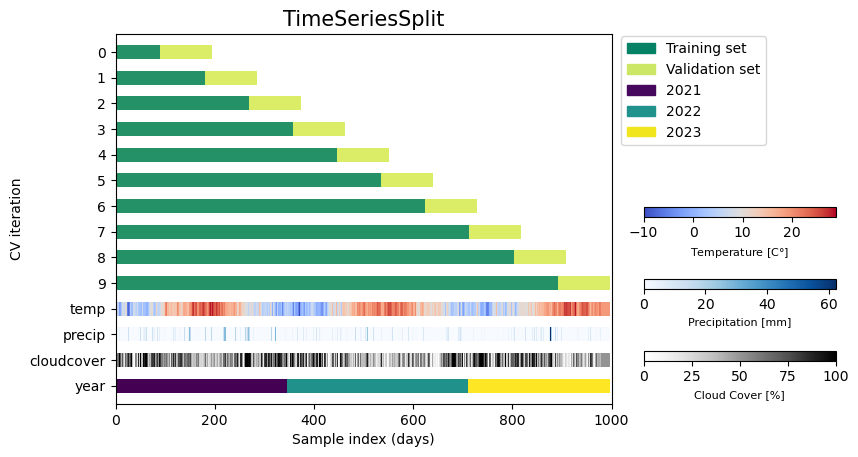

In [64]:
fig = plt.figure()
ax = plt.subplot(111)

plot_cv_indices(time_series_cv, weather_data_with_lags, ax, fig, n_splits)

plt.show()

#### 3.4. Linear Model Temperature

First we make simple autoregressive model with pipeline for Temperature:

In [65]:
temp_column_selector = make_column_selector(pattern = "temp_") # select "temp_n", excluding "temp"

In [66]:
temp_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy = "mean")),
        ("scale", MinMaxScaler())
    ]
)

In [67]:
feature_preprocessor = ColumnTransformer(
    transformers=[
        ("temp", temp_transformer, temp_column_selector)
    ],
    verbose_feature_names_out = False,
    # sparse_threshold=0.0
)

In [68]:
weather_features = feature_preprocessor.fit_transform(weather_data_with_lags)

In [69]:
feature_preprocessor.get_feature_names_out()

array(['temp_1', 'temp_2', 'temp_3', 'temp_4', 'temp_5', 'temp_6',
       'temp_7', 'temp_8', 'temp_9', 'temp_10'], dtype=object)

In [70]:
weather_features.shape

(989, 10)

In [71]:
temp_target = weather_data_with_lags.temp

In [72]:
pipe_autoregression = Pipeline(
    steps=[
        ("preprocess", feature_preprocessor),
        ("model", LinearRegression())
    ]
)

For loss function we have kept the default r2 for Linear Regression. For evaluation along with r2, we have chosen MSE because of higher penalty for larger errors, MAE and max error because they are very intuitively interpreted. In sklearn's cross validation they are readily available as scorers, but except r2 as a negative of the original metric:

+ _"All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric."_

In [73]:
scoring_metrics = "r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"

In [74]:
cv_results_temperature = cross_validate(
    pipe_autoregression, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.temp, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

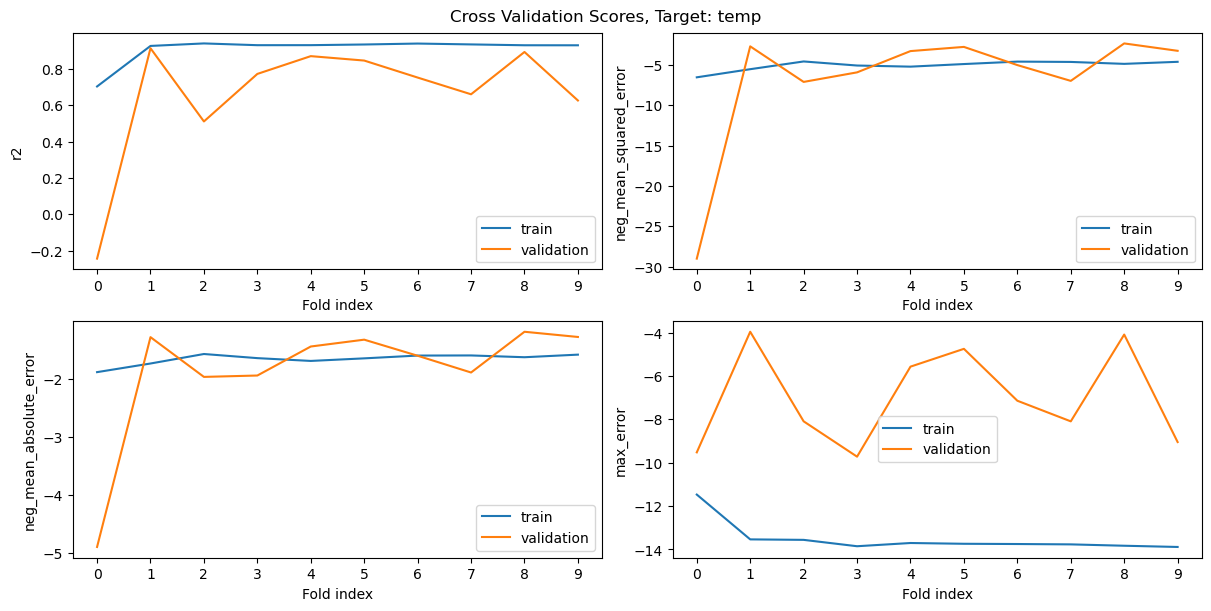

In [75]:
plot_score_cv(cv_results_temperature)

From the plots of cross-validation scores we can see that the first fold is useless, model has low scores even on the training set.

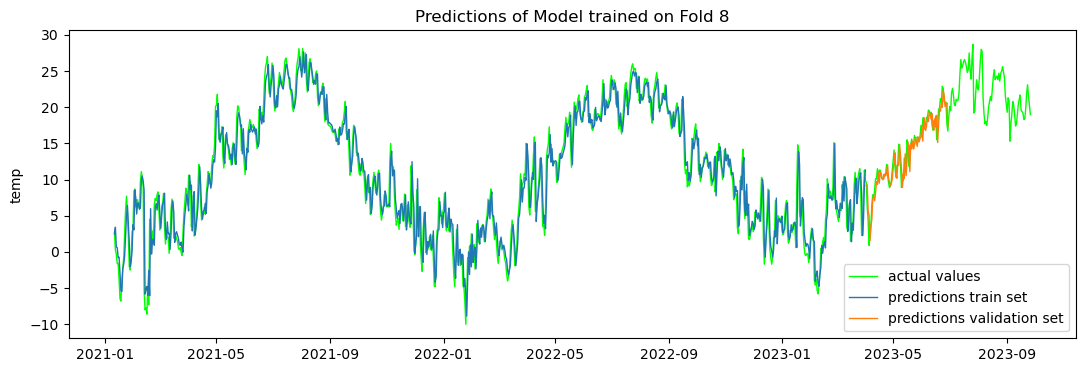

In [76]:
plot_cv_predictions(cv_results_temperature, weather_data_with_lags, "temp", n_fold = 8)

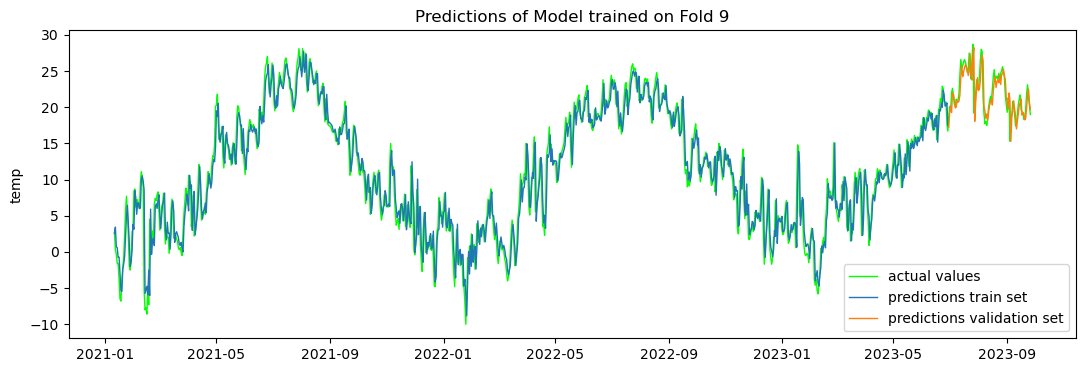

In [77]:
plot_cv_predictions(cv_results_temperature, weather_data_with_lags, "temp", n_fold = 9)

Overall predictions are not too bad, but the model clearly underestimates peak values. That, along with the cv scores is indication of high bias.

Let's explore the coefficients of each estimator:

In [78]:
feature_names = pipe_autoregression[-2].get_feature_names_out()

In [79]:
pd.DataFrame([estimator["model"].coef_ for estimator in cv_results_temperature["estimator"]], columns = feature_names).rename_axis("Fold_Index")

temp_1    temp_2    temp_3    temp_4    temp_5    temp_6  \
Fold_Index                                                                
0           20.478936 -3.807335  0.544722 -4.493322  5.887582 -7.845329   
1           38.644530 -6.014341 -1.523119 -2.769755  8.852627 -9.672838   
2           40.109784 -8.371111  1.923804 -4.430105  7.533786 -7.734670   
3           38.233823 -8.009776  1.004961  0.125974  3.098596 -4.346799   
4           39.143693 -8.197227  2.534011 -2.019205  3.667419 -2.523765   
5           39.214276 -8.244548  2.474718 -2.138295  3.389075 -2.161760   
6           39.564377 -8.342936  2.331403 -2.237550  3.148686 -1.717520   
7           39.083562 -8.394686  2.589445 -2.603153  3.391680 -0.714419   
8           39.329545 -9.292093  2.151740 -0.186465  2.053207 -0.367009   
9           39.082373 -8.704841  1.728994 -0.033217  1.837280 -0.089666   

              temp_7    temp_8    temp_9   temp_10  
Fold_Index                                          
0           6.435569 -3.208044  3.392668 -3.647860  
1           7.915806 -3.639064  4.376643 -1.255764  
2           8.818335 -6.358778  5.335461 -1.021360  
3           6.530963 -2.672281  1.684801  0.217797  
4           5.074643 -1.845846  2.489502 -1.171829  
5           5.399130 -2.161451  2.706500 -1.192627  
6           4.741696 -2.194029  2.582405 -0.596912  
7           3.662992 -1.132329  0.650858  0.768354  
8           2.819206 -1.580097  1.587215  0.707372  
9           2.586145 -0.847776  0.763565  0.926300

As expected first lag is by far the most important predictor. For now we keep them all and assume adding more lags would not be beneficial.

skip autoregression for precip and cloudcover

### 3.3. Linear Model Base Features

In order to improve our model we add the other base features and evaluate all 3 targets. As sklearn's approach to multi output regression is making independant models for each target anyway, we make three separate models for easier evaluation and visualisation:

In [80]:
precip_column_selector = make_column_selector(pattern = "precip_") # excluding "precip"

In [81]:
cloudcover_column_selector = make_column_selector(pattern = "cloudcover_") # excluding "cloudcover"

In [82]:
log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

In [83]:
precip_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy = "constant", fill_value = 0)),
        ("log_transform", log_transformer),
        ("scale", MinMaxScaler())
    ]
)

In [84]:
cloudcover_transformer = Pipeline(
    steps=[
        ("impute", SimpleImputer(strategy = "constant", fill_value = 0)),
        ("scale", MinMaxScaler())
    ]
)

In [85]:
feature_preprocessor = ColumnTransformer(
    transformers=[
        ("temp", temp_transformer, temp_column_selector),
        ("precip", precip_transformer, precip_column_selector),
        ("cloudcover", cloudcover_transformer, cloudcover_column_selector)
    ],
    verbose_feature_names_out = False,
    # sparse_threshold=0.0
)

In [86]:
pipe_linear_regression_base_features = Pipeline(
    steps=[
        ("preprocess", feature_preprocessor),
        ("model", LinearRegression())
    ]
)

In [87]:
# just checking, actual fit inside the cv
pipe_linear_regression_base_features.fit(weather_data_with_lags, weather_data_with_lags.temp)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('temp',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001634AD18A90>),
                                                 ('precip',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('log_transform',
                                                                   FunctionTransformer(fe...
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001634A932110>),
                                                 ('cloudcover',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001634ADA8610>)],
                                   verbose_feature_names_out=False)),
                ('model', LinearRegression())])

In [88]:
pipe_linear_regression_base_features[:-1].get_feature_names_out()

array(['temp_1', 'temp_2', 'temp_3', 'temp_4', 'temp_5', 'temp_6',
       'temp_7', 'temp_8', 'temp_9', 'temp_10', 'precip_1', 'precip_2',
       'precip_3', 'precip_4', 'precip_5', 'precip_6', 'precip_7',
       'precip_8', 'precip_9', 'precip_10', 'cloudcover_1',
       'cloudcover_2', 'cloudcover_3', 'cloudcover_4', 'cloudcover_5',
       'cloudcover_6', 'cloudcover_7', 'cloudcover_8', 'cloudcover_9',
       'cloudcover_10'], dtype=object)

In [89]:
cv_results_temperature = cross_validate(
    pipe_linear_regression_base_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.temp, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

In [90]:
# cv_results_temperature

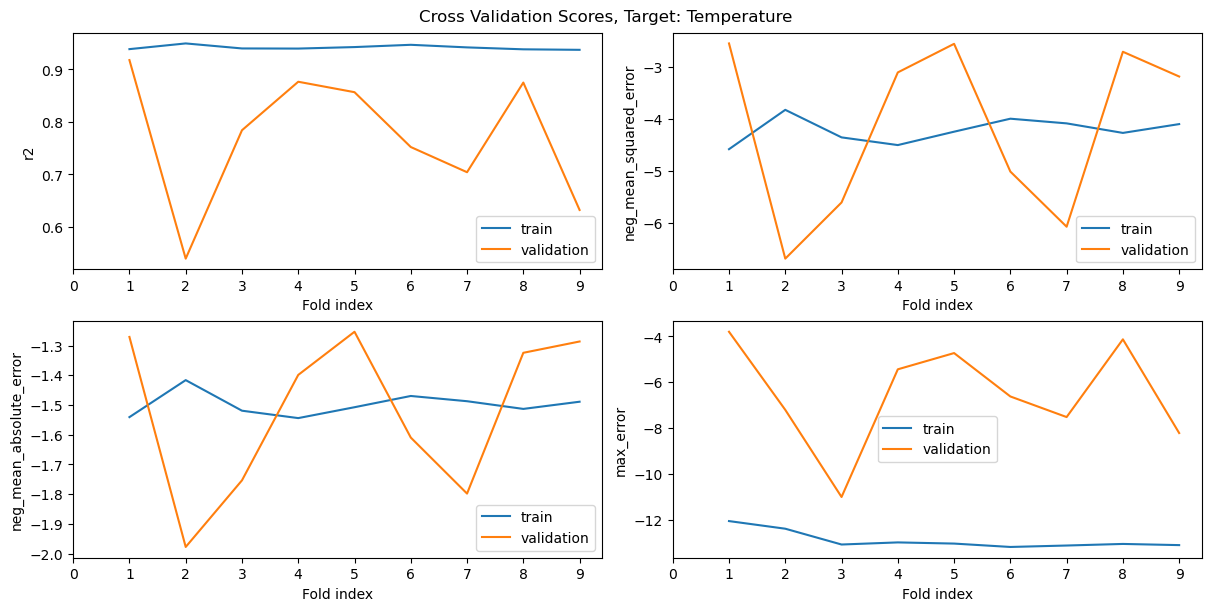

In [94]:
plot_score_cv(cv_results_temperature, target = "Temperature", skip_folds = 1)

Scores are better than these of the previous model, but this model still has high bias.

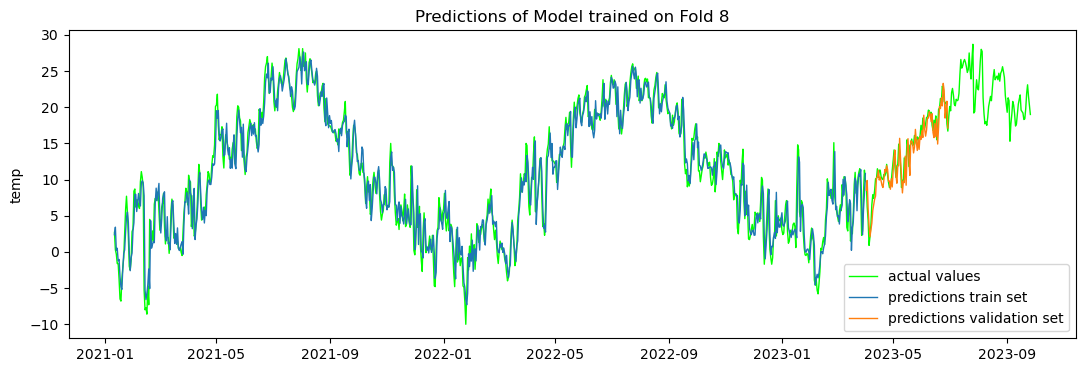

In [95]:
plot_cv_predictions(cv_results_temperature,  weather_data_with_lags, "temp", n_fold = 8)

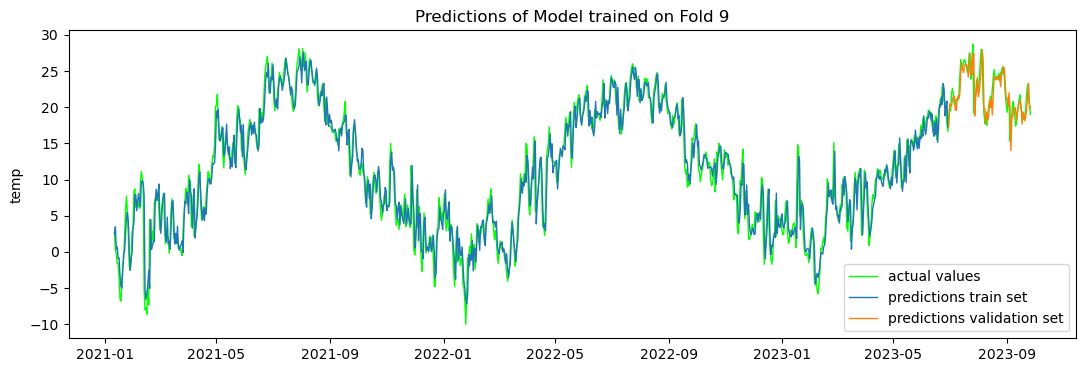

In [96]:
plot_cv_predictions(cv_results_temperature,  weather_data_with_lags, "temp", n_fold = 9)

Let's explore the coefficients of the model:

In [98]:
feature_names = pipe_linear_regression_base_features[-2].get_feature_names_out()

In [99]:
coefficients_temp = pd.DataFrame([estimator["model"].coef_ for estimator in cv_results_temperature["estimator"]], columns = feature_names).rename_axis("Fold_Index")

In [100]:
coefficients_temp.filter(regex=("temp"))

temp_1    temp_2    temp_3    temp_4    temp_5    temp_6  \
Fold_Index                                                                
0           18.587102 -4.079364  3.116180 -5.053692  4.572908 -6.772952   
1           34.383501 -4.496522  1.077331 -2.321202  5.397575 -6.593020   
2           35.734363 -6.499184  3.989204 -4.259658  4.962526 -4.846860   
3           34.770371 -4.879509  2.024399 -1.212540  1.799465 -2.315931   
4           35.680515 -5.639626  3.871213 -2.556401  1.540901 -0.007852   
5           35.300412 -5.202111  3.590585 -2.026220  1.042836 -0.760118   
6           35.866719 -5.268247  3.344629 -2.236011  0.693152 -0.376170   
7           36.284004 -6.150721  3.186739 -2.320551  1.593780  0.594008   
8           36.563035 -6.994844  2.800390 -0.519344  0.480167  1.252764   
9           36.500491 -6.645206  2.340430 -0.124872  0.358150  1.365511   

              temp_7    temp_8    temp_9   temp_10  
Fold_Index                                          
0           6.963438 -2.621631  2.879279 -3.928251  
1           8.079659 -1.685892  2.314838 -0.989807  
2           7.972143 -3.254225  3.577667 -1.128744  
3           5.751707 -0.175903 -1.017937  1.279529  
4           5.059714 -0.899415  0.123569 -0.096738  
5           5.986717 -1.103011  0.260657 -0.159201  
6           5.223296 -1.011569  0.382505  0.247753  
7           3.266303 -0.398204 -0.358312  1.316950  
8           2.422559 -0.907312 -0.066376  1.516309  
9           2.212739 -0.093737 -0.689633  1.538166

In [101]:
coefficients_temp.filter(regex=("precip"))

precip_1  precip_2  precip_3  precip_4  precip_5  precip_6  \
Fold_Index                                                               
0          -0.999393  1.074796 -0.264123  1.527824 -0.495973  0.680576   
1          -0.321054  1.487616  0.107204 -0.099239 -0.270904  0.020433   
2           0.011947  1.477637 -0.514197 -0.277474 -0.042740 -0.174529   
3          -0.812606  1.587034  0.245925 -0.200786 -0.214352  0.085126   
4          -0.779761  0.918081  0.318297  0.101720 -0.576221  0.160974   
5          -0.551533  1.071888  0.206719  0.292981 -0.179219 -0.226291   
6          -0.574673  1.009471  0.318245  0.123604 -0.119422 -0.382734   
7          -0.730546  1.043071  0.416805 -0.045577 -0.378353 -0.205207   
8          -0.709946  1.053554  0.545354 -0.031099 -0.551240 -0.199429   
9          -0.572769  0.967322  0.441422  0.003844 -0.342066 -0.133076   

            precip_7  precip_8  precip_9  precip_10  
Fold_Index                                           
0          -0.439868 -0.257803  0.982641   0.213627  
1          -0.496186  0.240959  0.426493  -0.418115  
2          -0.237452  0.227775  0.064346  -0.433236  
3          -0.351828  0.347430 -0.195850  -0.581649  
4           0.095976  0.079806 -0.201190  -0.115818  
5           0.129468  0.025299 -0.165002  -0.044508  
6           0.085570  0.045677 -0.005675  -0.195566  
7          -0.142171  0.191574 -0.271972   0.017289  
8           0.113874  0.310305 -0.270030   0.111120  
9          -0.024091  0.351365 -0.226746   0.179173

In [102]:
coefficients_temp.filter(regex=("cloudcover"))

cloudcover_1  cloudcover_2  cloudcover_3  cloudcover_4  \
Fold_Index                                                           
0              -3.297043      0.482275     -0.363478     -0.771358   
1              -3.770595      0.057783      1.013050     -0.751831   
2              -3.623500      0.230650      0.975264     -0.389374   
3              -3.156114      0.210662      0.522994     -0.095843   
4              -3.076891      0.362445     -0.035683      0.128237   
5              -3.273697      0.339611      0.154610      0.113704   
6              -3.224764      0.436784      0.121221      0.170308   
7              -2.822666      0.319508     -0.048372      0.037861   
8              -2.947430      0.446283     -0.370764      0.192536   
9              -2.798897      0.490782     -0.193539     -0.003559   

            cloudcover_5  cloudcover_6  cloudcover_7  cloudcover_8  \
Fold_Index                                                           
0              -0.407981     -0.246648      0.227022      1.907814   
1               0.633364      0.345054      0.602331      1.240586   
2               0.556463     -0.285907      0.656724      1.253383   
3               0.426609     -0.766956      1.205401      0.499232   
4               0.718344     -1.043295      1.209759      0.880946   
5               0.502056     -0.812216      1.002062      0.824831   
6               0.618481     -0.944976      0.941228      0.720466   
7               1.108139     -1.033837      1.020344      0.443910   
8               1.131875     -1.109498      1.060140      0.240370   
9               1.288504     -1.222749      1.122466      0.277037   

            cloudcover_9  cloudcover_10  
Fold_Index                               
0              -1.321374      -0.184811  
1               0.385845       0.555226  
2               0.532359       0.911169  
3               0.276975       0.969141  
4              -0.293388       0.527091  
5              -0.372028       0.387805  
6              -0.607412       0.612792  
7              -0.540403       0.627690  
8              -0.496243       0.111589  
9              -0.520552       0.221611

In order to make a model with target precipitation we need to impute the NaNs. As we know that most of them are not missing values, but mean that there was no rain or snow that day, we safely impute with 0.

In [104]:
weather_data_with_lags.precip = weather_data_with_lags.precip.fillna(0)

In [105]:
cv_results_precip = cross_validate(
    pipe_linear_regression_base_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.precip, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

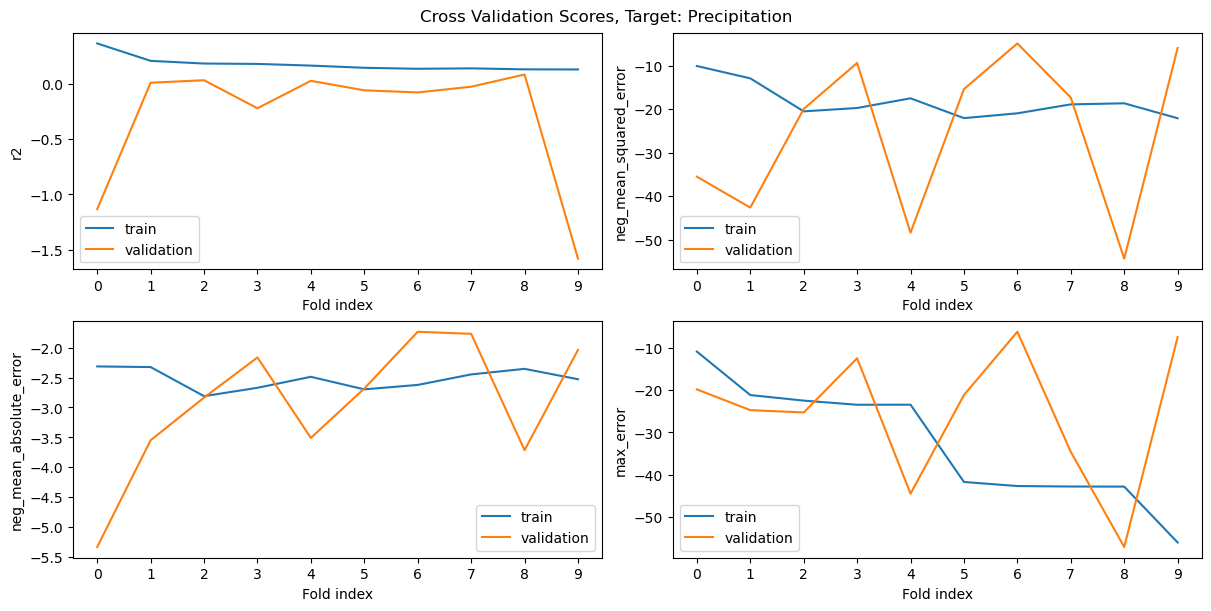

In [106]:
plot_score_cv(cv_results_precip, target = "Precipitation")

Well, disastrous results. R2 is even negative, which means we would be better off predicting the mean value then trying to make a model. These results are no surprise - we know from the EDA that precipitation has exponential distribution and linear regression is unlikely to describe it well, especially since we have applied logarithmic transformation on the input variables (the lags), but not on the target. We keep target precipitation without transformation for now for consistency and easier interpretation of the cv scores, but keep in mind to come back to this problem later.

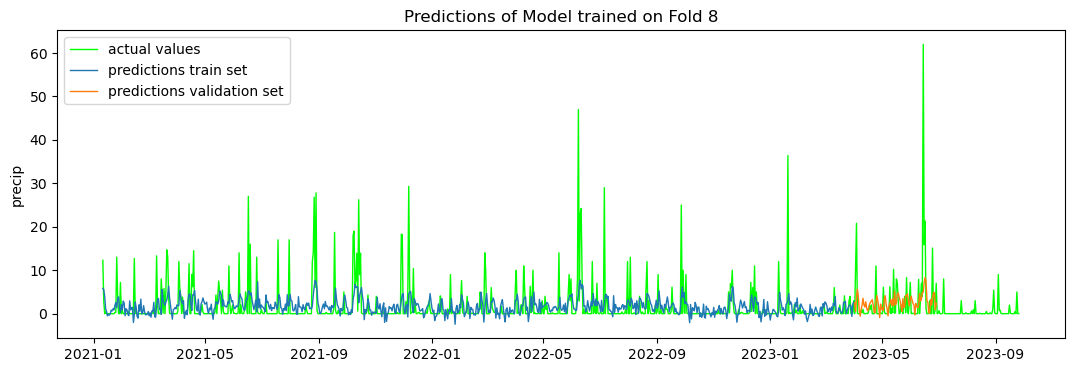

In [107]:
plot_cv_predictions(cv_results_precip,  weather_data_with_lags, "precip", n_fold = 8)

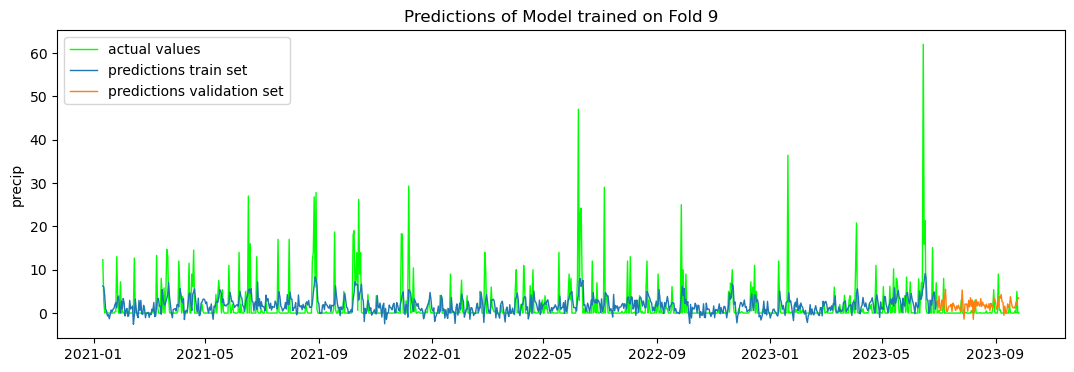

In [108]:
plot_cv_predictions(cv_results_precip,  weather_data_with_lags, "precip", n_fold = 9)

We also need some postprocessor that limits the precipitation to 0 as negative quantities of rain are not possible.


We make a model with target cloudcover, and again impute with 0 (most NaNs mean "no clouds" and are not missing value):

In [109]:
weather_data_with_lags.cloudcover = weather_data_with_lags.cloudcover.fillna(0)

In [110]:
cv_results_cloudcover = cross_validate(
    pipe_linear_regression_base_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.cloudcover, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

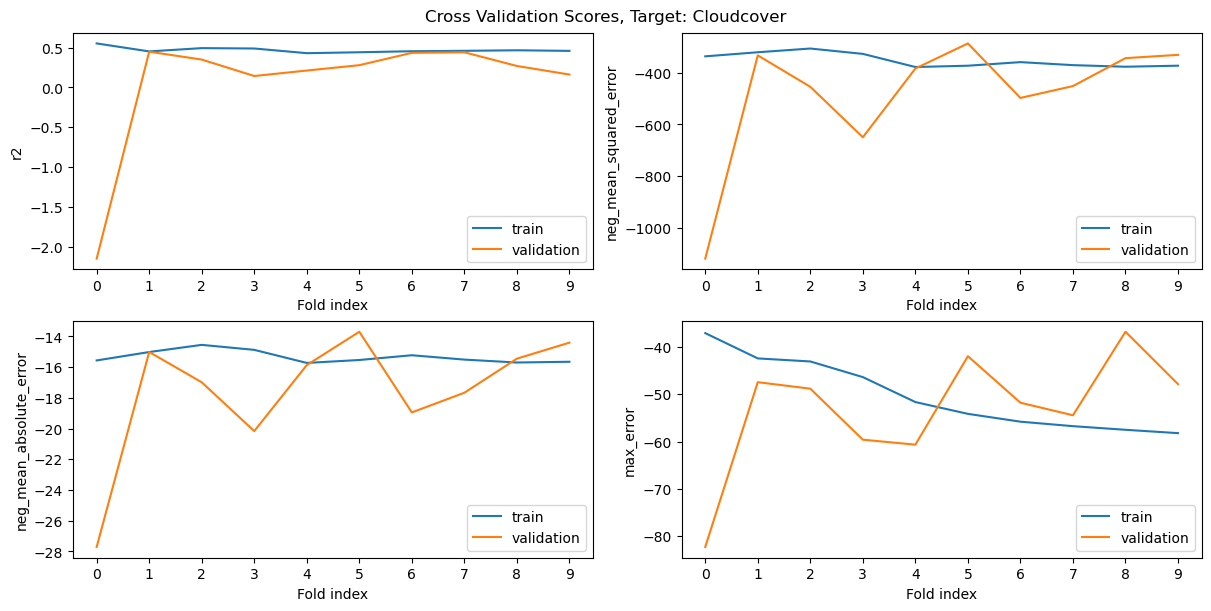

In [111]:
plot_score_cv(cv_results_cloudcover, target = "Cloudcover")

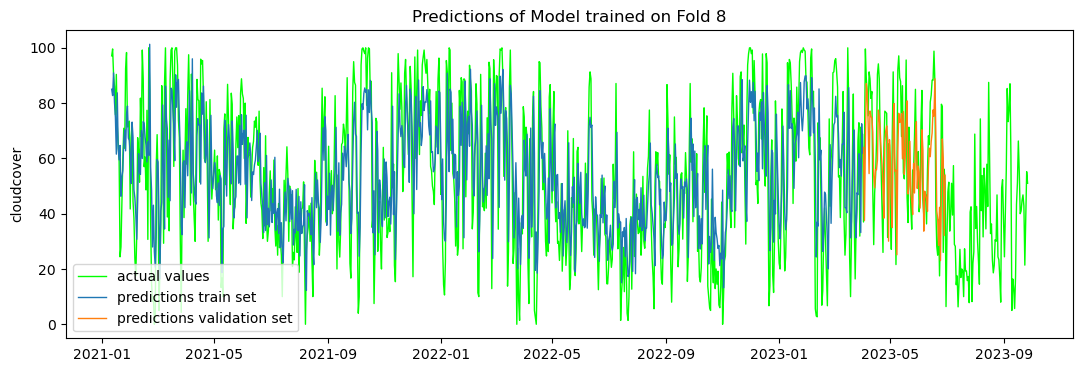

In [112]:
plot_cv_predictions(cv_results_cloudcover,  weather_data_with_lags, "cloudcover", n_fold = 8)

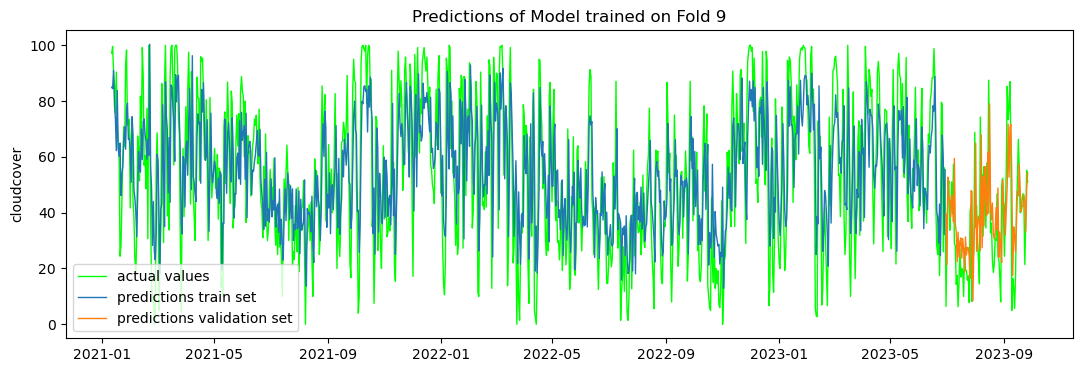

In [113]:
plot_cv_predictions(cv_results_cloudcover,  weather_data_with_lags, "cloudcover", n_fold = 9)

Results are not impressive for cloudcover too.

To make a better model we need more input information.

## Adding Time-Related Features

To help our model perform better we add features that are derivatives of datetime - year, month, week of year and day of year. We hope that these new features will add information about seasonality.

In [127]:
weather_data_with_lags["dt_year"] = weather_data_with_lags.datetime.dt.year  
weather_data_with_lags["dt_month"] = weather_data_with_lags.datetime.dt.month  
weather_data_with_lags["dt_week_of_year"] = weather_data_with_lags.datetime.dt.isocalendar().week 
weather_data_with_lags["dt_day_of_year"] = weather_data_with_lags.datetime.dt.day_of_year 

All new features are encoded as ordinal categories - years 2020 to 2023, months 1 to 12, weeks 1 to 52 and days 1 to 365. This is not very useful for 
month, week and day since they are circular variables (after December (12) comes January (1) again etc.). This is why we apply cosine transform with each variable's period. For simplicity we disregard leap years and assume it will not be a problem. Although month is also circular we treat it as nominal category, because this way we give our model information on seasonality that is not gradually changing from one month to another (chances for snow in April are still quite high and practically 0 for May, for Sofia at least). Year is also treated as nominal, not ordinal category since we have no reason to believe there will be some trend throughout the years, and even if it were, we have too few data for it to be of any importance.

In [128]:
def sin_name_out(self, input_features):
    return [f"{feature}_sin" for feature in input_features]

def cos_name_out(self, input_features):
    return [f"{feature}_cos" for feature in input_features]

In [129]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi), feature_names_out = sin_name_out)


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi), feature_names_out = cos_name_out)



In [130]:
time_transformer = ColumnTransformer(
        transformers=[
            ("nominal", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["dt_year"]), # was ["dt_year", "dt_month"]
            ("week_sin", sin_transformer(52), ["dt_week_of_year"]),
            ("week_cos", cos_transformer(52), ["dt_week_of_year"]),
            ("day_sin", sin_transformer(365), ["dt_day_of_year"]),
            ("day_cos", cos_transformer(365), ["dt_day_of_year"]),
            ],
    verbose_feature_names_out = False
)

Default setting of OneHotEncoder - handle_unknown="error" was changed to handle_unknown="ignore", because some folds have categories in the validation set, that are not present in the training set. For example, years seen during fit are 2021 and 2022, and transforming 2023 is not possible.  

At first we tried handling `dt_month` as nominal category, hoping it will give the model more flexibility, but it led to exploding gradients - coefficients and intercept with order of $e^{14}$. This is less likely to happen in a model with more independent features or one with regularization or dimensionality reduction, so we may try this approach later in this work. In the current experiment `dt_month` is ignored.

In [131]:
time_features = time_transformer.fit_transform(weather_data_with_lags) # just checking, actual fit inside cv

In [132]:
time_transformer.get_feature_names_out()

array(['dt_year_2021', 'dt_year_2022', 'dt_year_2023',
       'dt_week_of_year_sin', 'dt_week_of_year_cos', 'dt_day_of_year_sin',
       'dt_day_of_year_cos'], dtype=object)

In [133]:
len(time_transformer.get_feature_names_out())

7

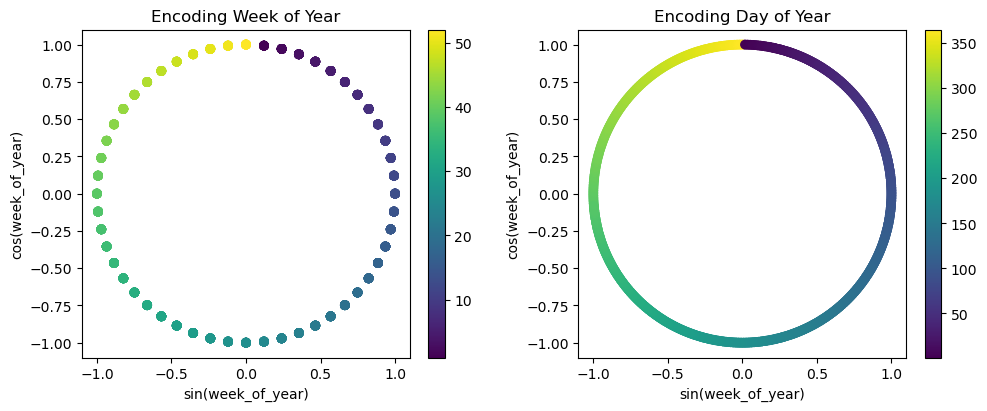

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout = True)

features = ["dt_week_of_year", "dt_day_of_year"]
titles = ["Encoding Week of Year", "Encoding Day of Year"]
sin_column_index = [3, 5]

for i, ax in enumerate(axs):
    scatter = ax.scatter(time_features[:,sin_column_index[i]], time_features[:,sin_column_index[i] + 1], c=weather_data_with_lags[features[i]])
    colorbar = fig.colorbar(scatter)
    
    ax.set_title(titles[i])
    ax.set_aspect("equal")
    ax.set(
        xlabel="sin(week_of_year)",
        ylabel="cos(week_of_year)",
    )

plt.show()

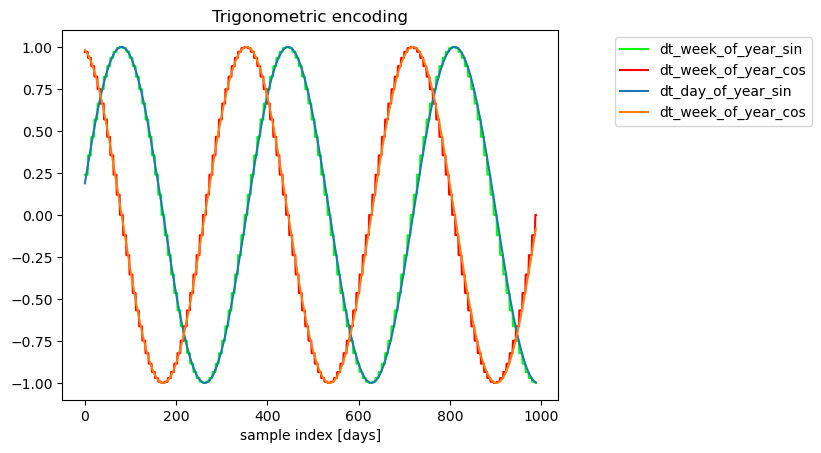

In [135]:
plt.plot(weather_data_with_lags.index, time_features[:,3], c = "lime", label = "dt_week_of_year_sin")
plt.plot(weather_data_with_lags.index, time_features[:,4], c = "red", label = "dt_week_of_year_cos")

plt.plot(weather_data_with_lags.index, time_features[:,5], label = "dt_day_of_year_sin")
plt.plot(weather_data_with_lags.index, time_features[:,6], label = "dt_week_of_year_cos")

plt.xlabel("sample index [days]")
plt.title("Trigonometric encoding")
plt.legend(bbox_to_anchor=(1.1, 1))

plt.show()

Making a model based on time features only:

In [143]:
pipe_linear_time_features = Pipeline(
    steps=[
        ("time_transform", time_transformer),
        ("model", LinearRegression())
    ]
)

In [144]:
pipe_linear_time_features.fit(weather_data_with_lags, weather_data_with_lags.temp) # just checking

Pipeline(steps=[('time_transform',
                 ColumnTransformer(transformers=[('nominal',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['dt_year']),
                                                 ('week_sin',
                                                  FunctionTransformer(feature_names_out=<function sin_name_out at 0x000001634AE29620>,
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x000001634AE2B600>),
                                                  ['dt_week_of_year']),
                                                 ('week_cos',
                                                  Funct...
                                                  FunctionTransformer(feature_names_out=<function sin_name_out at 0x000001634AE29620>,
                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x000001634AE28AE0>),
                                                  ['dt_day_of_year']),
                                                 ('day_cos',
                                                  FunctionTransformer(feature_names_out=<function cos_name_out at 0x000001634AE2B380>,
                                                                      func=<function cos_transformer.<locals>.<lambda> at 0x000001634AE2A020>),
                                                  ['dt_day_of_year'])],
                                   verbose_feature_names_out=False)),
                ('model', LinearRegression())])

In [145]:
# pipe_linear_time_features["model"].coef_

In [146]:
# pipe_linear_time_features["model"].intercept_

In [147]:
pipe_linear_time_features["model"].n_features_in_

7

In [148]:
cv_results_temperature = cross_validate(
    pipe_linear_time_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.temp, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

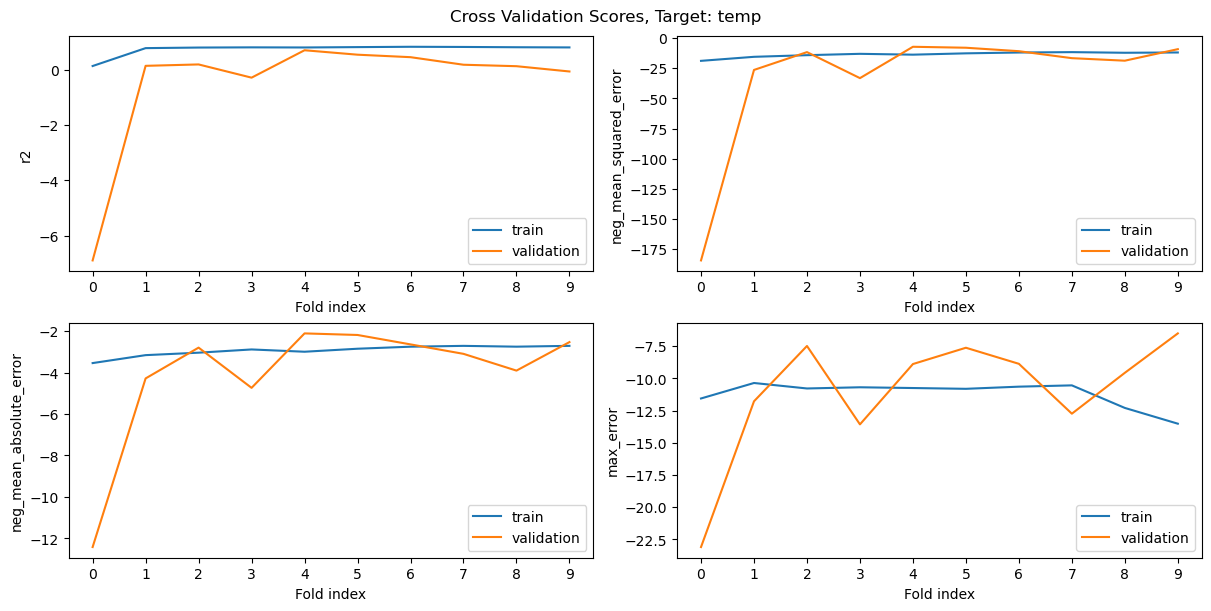

In [149]:
plot_score_cv(cv_results_temperature)

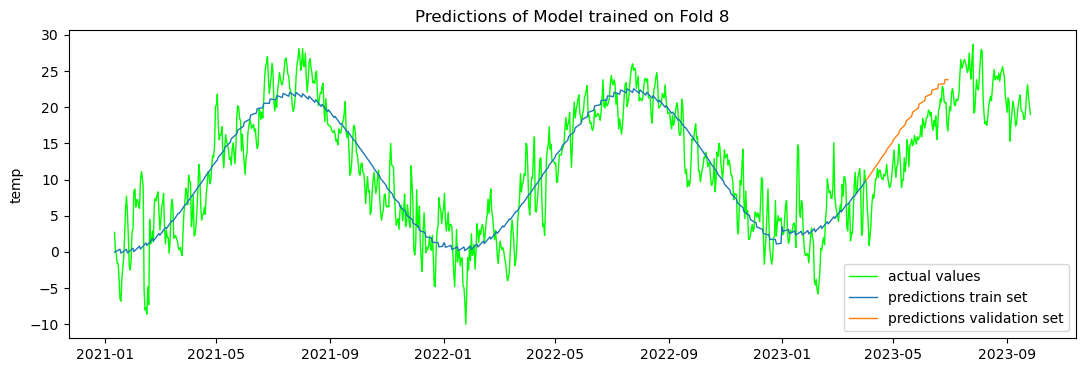

In [150]:
plot_cv_predictions(cv_results_temperature, weather_data_with_lags, "temp", n_fold = 8)

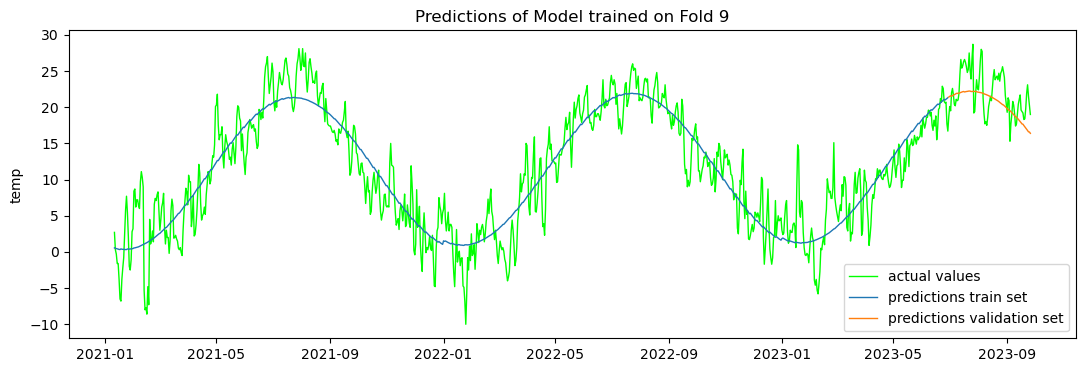

In [151]:
plot_cv_predictions(cv_results_temperature, weather_data_with_lags, "temp", n_fold = 9)

In [152]:
feature_names = pipe_linear_time_features[-2].get_feature_names_out()

In [153]:
pd.DataFrame([cv_results_temperature["estimator"][i]["model"].coef_ for i in range(10)], columns = feature_names)

dt_year_2021  dt_year_2022  dt_year_2023  dt_week_of_year_sin  \
0  0.000000e+00  6.610097e+00 -3.120227e+00            -3.310956   
1  0.000000e+00  1.611909e-01 -2.533670e+00            -6.627260   
2  0.000000e+00 -7.324886e+00 -4.148015e-02             3.600569   
3 -2.001369e+00  2.001369e+00 -9.671050e+00            -2.730470   
4 -1.093317e-01  1.093317e-01 -9.789625e+00            -2.207749   
5 -1.020488e-01  1.020488e-01 -6.400008e+00             2.972057   
6 -6.215732e-03  6.215732e-03 -4.566638e+00            -1.101230   
7 -8.750004e-01 -4.596172e-01  1.334618e+00            -5.300076   
8 -1.027065e+00 -6.119749e-01  1.639040e+00            -5.192608   
9 -8.092210e+13 -8.092210e+13 -8.092210e+13             1.386528   

   dt_week_of_year_cos  dt_day_of_year_sin  dt_day_of_year_cos  
0             0.561005                 NaN                 NaN  
1            -6.825594                 NaN                 NaN  
2           -10.436051                 NaN                 NaN  
3             6.094136           -7.693357                 NaN  
4             6.127876           -8.199424                 NaN  
5             2.768491          -13.424842                 NaN  
6             1.012473           -9.401619                 NaN  
7            -0.774982            1.527036           -9.392335  
8             0.703634            1.418810          -10.856127  
9             1.431960           -5.142478          -11.237339

Time features model with target precipitation:

In [155]:
cv_results_precip = cross_validate(
    pipe_linear_time_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.precip, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

In [160]:
plot_score_cv(cv_results_precip, target = "precip")

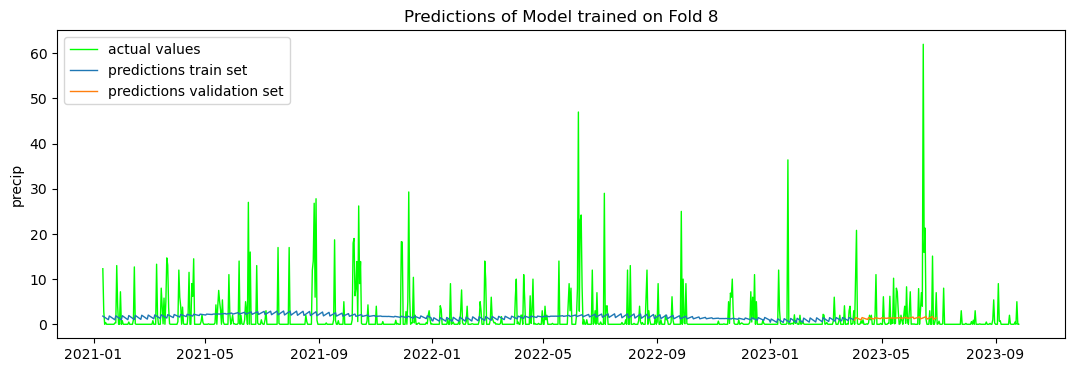

In [161]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 8)

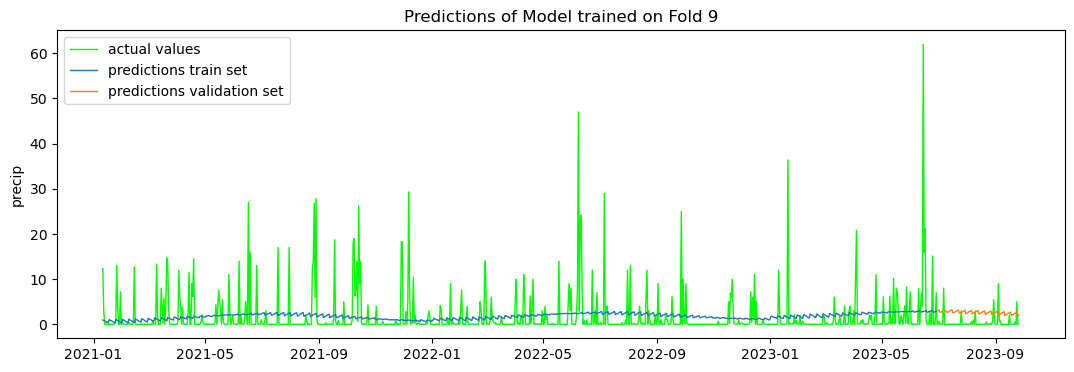

In [162]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 9)

In [163]:
pd.DataFrame([cv_results_precip["estimator"][i]["model"].coef_ for i in range(10)], columns = feature_names)

dt_year_2021  dt_year_2022  dt_year_2023  dt_week_of_year_sin  \
0  0.000000e+00  8.572553e+00 -1.671717e+00           -13.825537   
1  0.000000e+00  3.600162e+00 -4.619526e+00            -2.720170   
2  0.000000e+00  6.040403e+00 -1.516025e+01            -6.797717   
3  6.832876e-01 -6.832876e-01  1.566415e+01           -11.225112   
4  3.601386e-01 -3.601386e-01  1.348301e+01            -4.234752   
5 -7.998045e-02  7.998045e-02  7.587150e+00            -4.063315   
6  1.288735e-01 -1.288735e-01  1.019613e+01            -6.698274   
7  7.152166e-01  2.455798e-01 -9.607965e-01             7.783875   
8  4.463447e-01 -2.493505e-02 -4.214097e-01             6.504360   
9 -4.371941e+14 -4.371941e+14 -4.371941e+14             4.810083   

   dt_week_of_year_cos  dt_day_of_year_sin  dt_day_of_year_cos  
0            -3.566826                 NaN                 NaN  
1             4.219326                 NaN                 NaN  
2            15.372210                 NaN                 NaN  
3           -16.062774           10.987832                 NaN  
4           -13.771586            3.939888                 NaN  
5            -8.086397            3.382207                 NaN  
6           -10.479263            6.142202                 NaN  
7            -8.018421           -7.932560            7.400783  
8            -6.069920           -6.658203            5.502714  
9            -6.235458           -5.012531            5.401272

Time features model on target cloudcover:

In [164]:
cv_results_cloudcover = cross_validate(
    pipe_linear_time_features, # Estimator
    weather_data_with_lags, # X
    weather_data_with_lags.cloudcover, # y
    scoring = scoring_metrics, 
    cv = time_series_cv, 
    return_train_score = True, 
    return_indices = True,
    return_estimator = True
)

In [165]:
# plot_score_cv(cv_results_cloudcover)

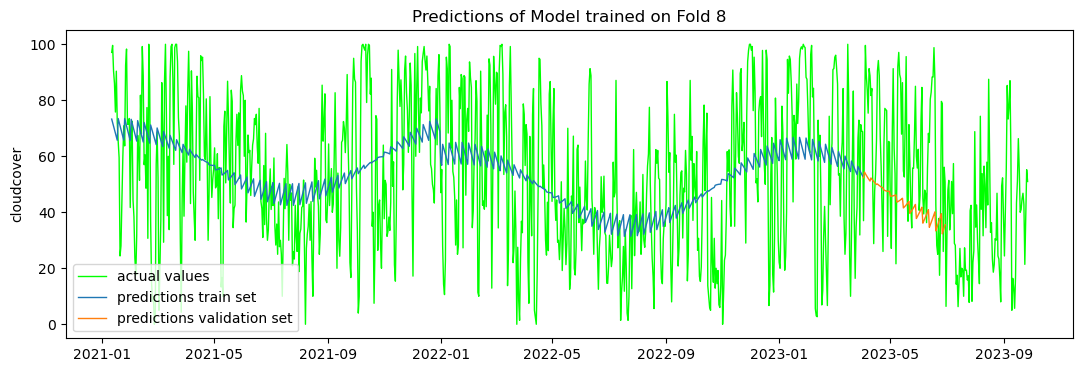

In [166]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 8)

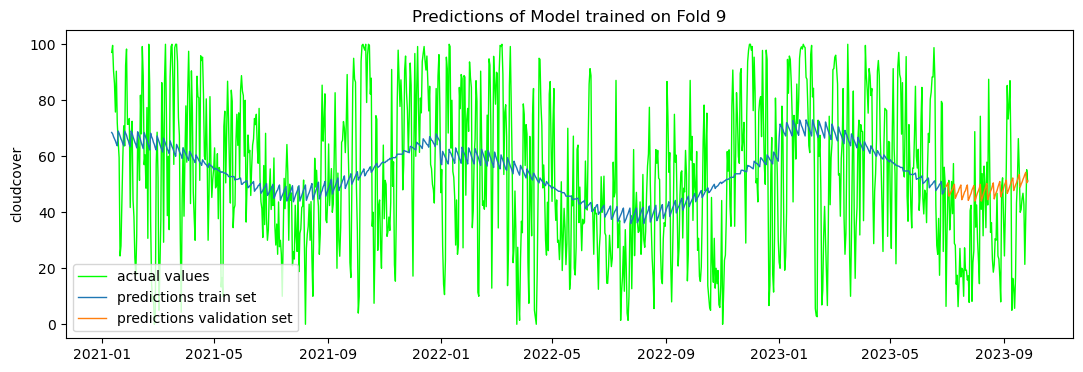

In [167]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 9)

In [168]:
pd.DataFrame([cv_results_cloudcover["estimator"][i]["model"].coef_ for i in range(10)], columns = feature_names)

dt_year_2021  dt_year_2022  dt_year_2023  dt_week_of_year_sin  \
0  0.000000e+00 -3.097940e+01 -1.037263e+02           -33.539937   
1  0.000000e+00  3.127643e+01 -8.373042e+01           -19.477964   
2  0.000000e+00  3.377071e+01 -7.007851e+01           -30.959153   
3  6.095979e+00 -6.095979e+00  7.204022e+01           -59.433088   
4  4.472994e+00 -4.472994e+00  6.360623e+01           -35.064666   
5  4.648772e+00 -4.648772e+00  7.355142e+01           -37.443412   
6  4.333971e+00 -4.333971e+00  8.115999e+01           -24.886787   
7  2.004141e+01  1.026319e+01 -3.030460e+01            74.170000   
8  6.360773e+00 -3.425401e+00 -2.935371e+00            70.211034   
9 -1.153994e+15 -1.153994e+15 -1.153994e+15            43.086870   

   dt_week_of_year_cos  dt_day_of_year_sin  dt_day_of_year_cos  
0            61.001396                 NaN                 NaN  
1            86.670143                 NaN                 NaN  
2            78.361181                 NaN                 NaN  
3           -68.848799           69.036615                 NaN  
4           -60.171749           45.154888                 NaN  
5           -70.160693           47.501294                 NaN  
6           -78.261676           35.196198                 NaN  
7           -35.583488          -70.356437           45.908352  
8           -26.091362          -66.388555           36.680127  
9           -35.396879          -39.251534           44.086984

Of course time features are not enough to fully describe our data, but we can see that they capture the seasonality quite well. For our next model we decide to keep only `day of year` and drop week of year, since they are practically the same thing but with different period; keep `month` and `year` as nominal category.

### Linear Model All Features

This model is trained on both time features and features with lags, not only the targets but all columns that we assume have some valuable information. It is important to notice that some of the features are highly correlated - `temp` is average of `tempmin` and `tempmax`, `dew` can be calculated from `temp`, `humidity` and `sealevelpressure`, `conditions` is describing the other features with words and `description` is just verbose `conditions`. This problem is addressed later in this work.

In [177]:
n_lags

10

In [178]:
numeric_normal = [
    "tempmax",
     "tempmin",
     "temp",
     "dew",
     "humidity",
     "windgust",
     "windspeed",
     "sealevelpressure",
     "cloudcover"    
]
numeric_log_features = [
    "precip"
]
numeric_cyclic_features = [
    "winddir"
]
categorical_features = [
    "preciptype",
    "conditions"
]
text_features = [
    "description"
]

In [179]:
# make_column_selector(pattern = "sno|temp")(weather_data_with_lags)

In [180]:
def lag_column_selector(lag_features): # ugly but it's working
   return  make_column_selector(pattern = "|".join([f"{feature}_" for feature in lag_features]))

In [181]:
# lag_column_selector(numeric_normal)(weather_data_with_lags)

Time features - one hot encoding for month and year and trigonometric transform for day.

In [185]:
preprozess_time_features = ColumnTransformer(
            transformers=[
                ("categorical", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ["dt_month", "dt_year"]),
                ("day_sin", sin_transformer(365), ["dt_day_of_year"]),
                ("day_cos", cos_transformer(365), ["dt_day_of_year"]),
            ],
    verbose_feature_names_out = False
)

Numeric normal features - numeric variables with close to normal distribution (see EDA) imputed with 0 (most NaNs are not missing values but indicate the absence of the feature) and scale them into range from 0 to 1.

In [186]:
preprozess_numeric_normal = Pipeline(
            steps=[
                ("impute", SimpleImputer(strategy = "constant", fill_value = 0)),
                ("scale", MinMaxScaler())
            ]
)

Numeric logarithmic features - in our case only precipitation - feature with exponential distribution, impute with 0 and apply logarithmic transformation. `np.log1p` means that 1 is added to each value, so that no error is raised from applying logarithm on zero.
$$log1p(x)=log(1+x)$$

In [189]:
preprozess_numeric_log = Pipeline(
            steps=[
                ("impute", SimpleImputer(strategy = "constant", fill_value = 0)),
                ("log_transform", FunctionTransformer(np.log1p, feature_names_out = "one-to-one"))
            ]
)

Numeric cyclic features - in our case wind direction - apply the same trigonometric transformation as on the cyclic time features. The period is 360 as the direction is encoded with degrees with 0 and 360 for North.

In [190]:
preprozess_numeric_cyclic = ColumnTransformer(  # TODO: remove hardcode
            transformers=[
                ("winddir_sin", sin_transformer(360), make_column_selector(pattern = "winddir")),
                ("winddir_cos", cos_transformer(360), make_column_selector(pattern = "winddir")),
            ],
    verbose_feature_names_out = False
)

In [191]:
# preprozess_numeric_cyclic.fit_transform(weather_data_with_lags)

In [192]:
# preprozess_numeric_cyclic.get_feature_names_out()

Preprocess multi categorical features - for these features we need multi hot encoding - something like OneHotEncoder, but for features with list-like observations. Closest thing to that in sklearn is MultiLabelBinalizer, however in it's supposed to be applied on targets, using it on features is strongly discouraged. Instead we use CountVectoriser with custom pattern and dense output (since we know that our categories are few). CountVectoriser implementation accepts only one feature per sample; keeping our lags in separate vectorizers was quite difficult and our solution is not very clean, but it is wahat it is.

In [194]:
token_pattern = r"(?u)\b[^,]+\b" # honorable mention to ChatGPT for outstanding knowledge in the field of RegEx patterns
# pattern means we keep words separated by space in single token (like "partially cloudy") and split only by comma

In [195]:
count_vec_test = CountVectorizer(token_pattern = token_pattern)

In [196]:
count_vec_test.fit_transform([
    "first, words with space,noSpaceAfterComma, word, word, lastWord", 
    "firstWord, words with space,noSpaceAfterComma, UPPerCase, lastWord"]).toarray()

array([[1, 0, 1, 1, 0, 2, 1],
       [0, 1, 1, 1, 1, 0, 1]], dtype=int64)

In [197]:
count_vec_test.vocabulary_

{'first': 0,
 'words with space': 6,
 'nospaceaftercomma': 3,
 'word': 5,
 'lastword': 2,
 'firstword': 1,
 'uppercase': 4}

In [198]:
multi_column_vectorizer = ColumnTransformer(
            transformers=[
                (x, CountVectorizer(token_pattern = token_pattern), x) for x in lag_column_selector(categorical_features)(weather_data_with_lags)
            ],
    verbose_feature_names_out = True
)

In [199]:
multi_column_vectorizer.fit_transform(weather_data_with_lags).shape

(989, 80)

In [200]:
len(multi_column_vectorizer.get_feature_names_out())

80

In [201]:
# "multi_column_vectorizer" needs to be first step in pipeline to work - input pd with column names not np
# Couldn't make it work with all columns / array - spent too much time in that rabbit hole
# Maybe should have made custom transformer instead of using CountVectorizr, but it's too late now

# preprozess_categorical = Pipeline(
#             steps=[
#                 ("impute", SimpleImputer(strategy = "constant", fill_value = "None")),
#                 ("multi_column_vectorizer", multi_column_vectorizer),
#             ]
# )

In [202]:
# Maybe add gazillion more columns with tfidf on description

# ColumnTransformer([(x, TfidfVectorizer(), x) for x in textual_columns])

Our final feature preprocessor:

In [203]:
preprozess_all_features = ColumnTransformer(
            transformers=[
                ("time_features", preprozess_time_features, make_column_selector(pattern = "dt_")),
                ("numeric_normal", preprozess_numeric_normal, lag_column_selector(numeric_normal)),
                ("numeric_log", preprozess_numeric_log, lag_column_selector(numeric_log_features)),
                ("numeric_cyclic", preprozess_numeric_cyclic, lag_column_selector(numeric_cyclic_features)),
                ("categorical", multi_column_vectorizer, lag_column_selector(categorical_features))
            ],
    verbose_feature_names_out = False
)

We check weather the pipeline is functional. Actual fitting and transforming the data is done inside the crossvalidation, separately for each fold.

In [207]:
preprozess_all_features.fit(weather_data_with_lags)

ColumnTransformer(transformers=[('time_features',
                                 ColumnTransformer(transformers=[('categorical',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                sparse_output=False),
                                                                  ['dt_month',
                                                                   'dt_year']),
                                                                 ('day_sin',
                                                                  FunctionTransformer(feature_names_out=<function sin_name_out at 0x000001634AE29620>,
                                                                                      func=<function sin_transformer.<locals>.<lambda> at 0x0000016351C33240>),
                                                                  ['dt_day_...
                                                                  CountVectorizer(token_pattern='(?u)\\b[^,]+\\b'),
                                                                  'conditions_9'),
                                                                 ('preciptype_10',
                                                                  CountVectorizer(token_pattern='(?u)\\b[^,]+\\b'),
                                                                  'preciptype_10'),
                                                                 ('conditions_10',
                                                                  CountVectorizer(token_pattern='(?u)\\b[^,]+\\b'),
                                                                  'conditions_10')]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000016352A7E490>)],
                  verbose_feature_names_out=False)

In [208]:
preprozess_all_features.transform(weather_data_with_lags).shape

(989, 217)

Linear model with all features:

In [212]:
pipe_linear_all_features = Pipeline(
    steps=[
        ("preprocess", preprozess_all_features),
        ("model", LinearRegression())
    ]
)

We run an experiment with the linear model evaluated with cross validation on time series split and log the results:

In [213]:
cv_results_temp = run_cv_experiment(
    pipe_linear_all_features, 
    weather_data_with_lags, 
    weather_data_with_lags.temp,
    time_series_cv, 
    experiment_name = "linear_all", 
    target_name = "temp",
    
    log_experiment = False # False for rerunning the notebook
)

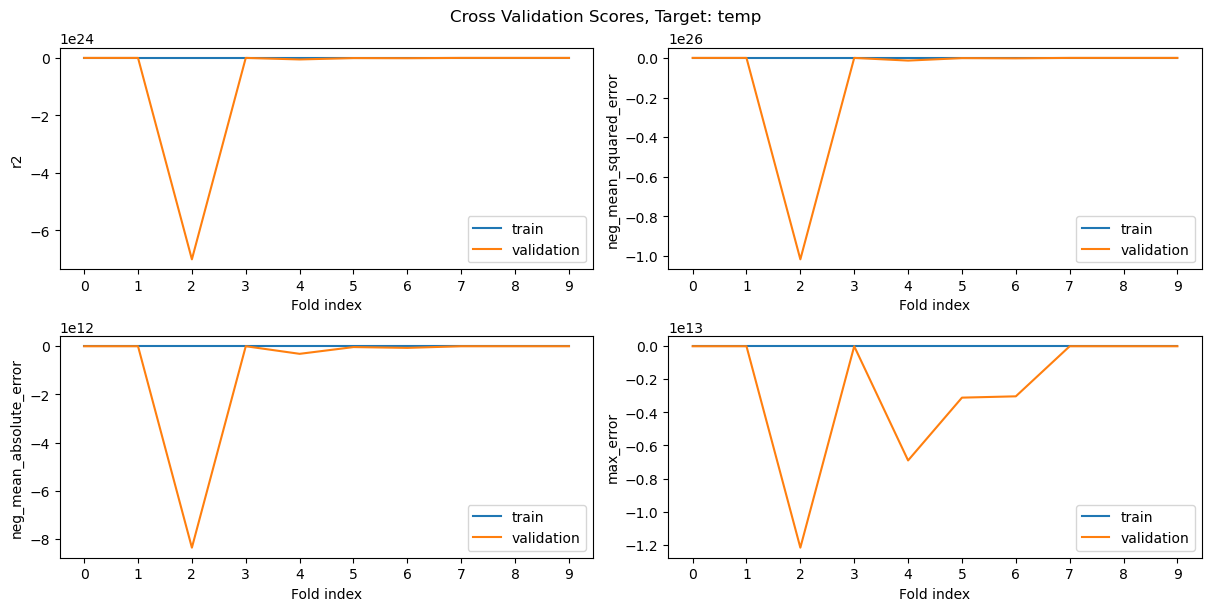

In [214]:
plot_score_cv(cv_results_temp)

We run into exploding gradients in the first few folds, so we skip them to see the meaningful results only:

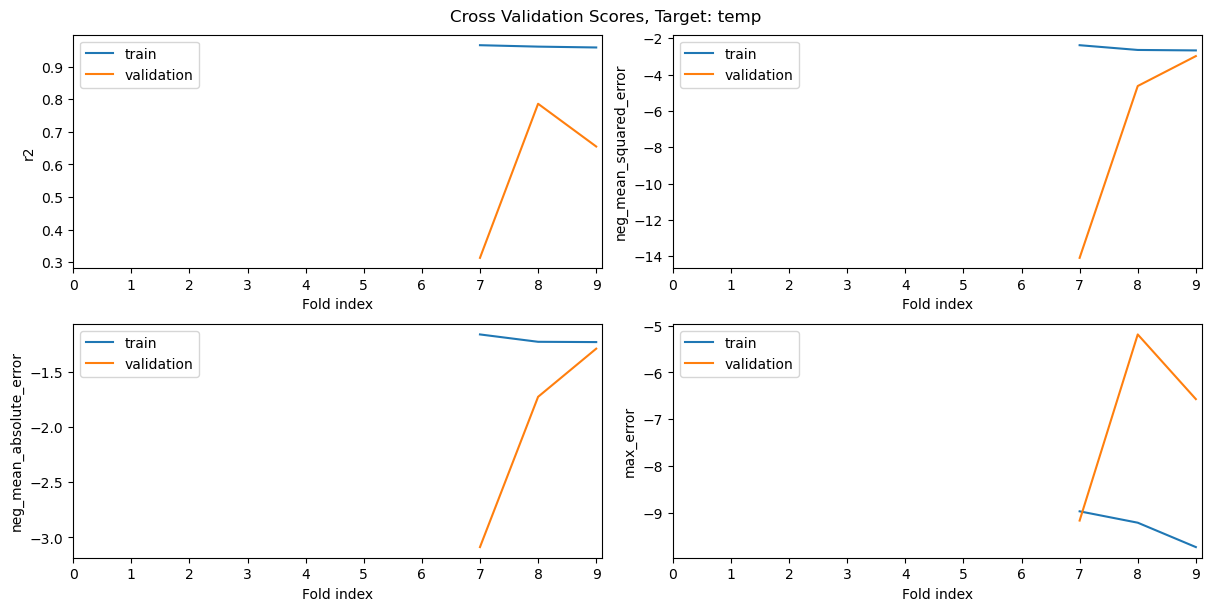

In [220]:
plot_score_cv(cv_results_temp, skip_folds = 7)

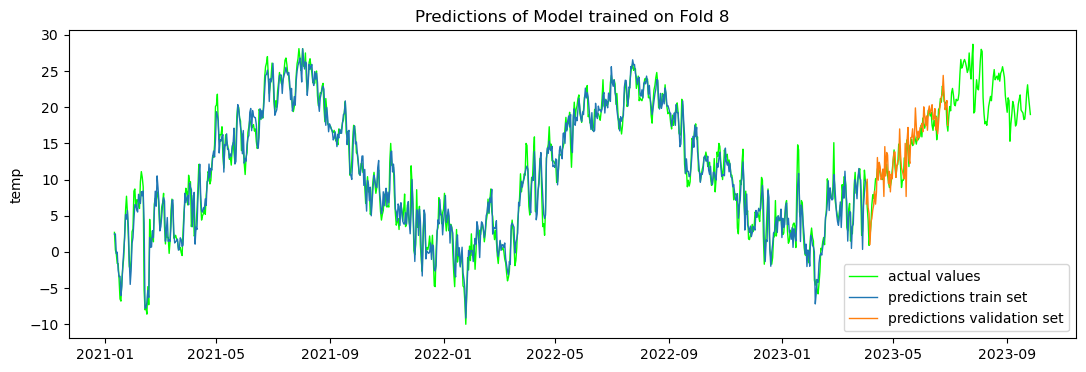

In [723]:
plot_cv_predictions(cv_results_temp, weather_data_with_lags, "temp", n_fold = 8)

In [724]:
plot_cv_predictions(cv_results_temp, weather_data_with_lags, "temp", n_fold = 9)

Last 2 folds preform almost well on training set, but quite bad on the validation sets. Let's see a model trained on precipitation: 

In [221]:
cv_results_precip = run_cv_experiment(
    pipe_linear_all_features, 
    weather_data_with_lags, 
    weather_data_with_lags.precip,
    time_series_cv, 
    experiment_name = "linear_all_features", 
    target_name = "precip",

    log_experiment = False
) 

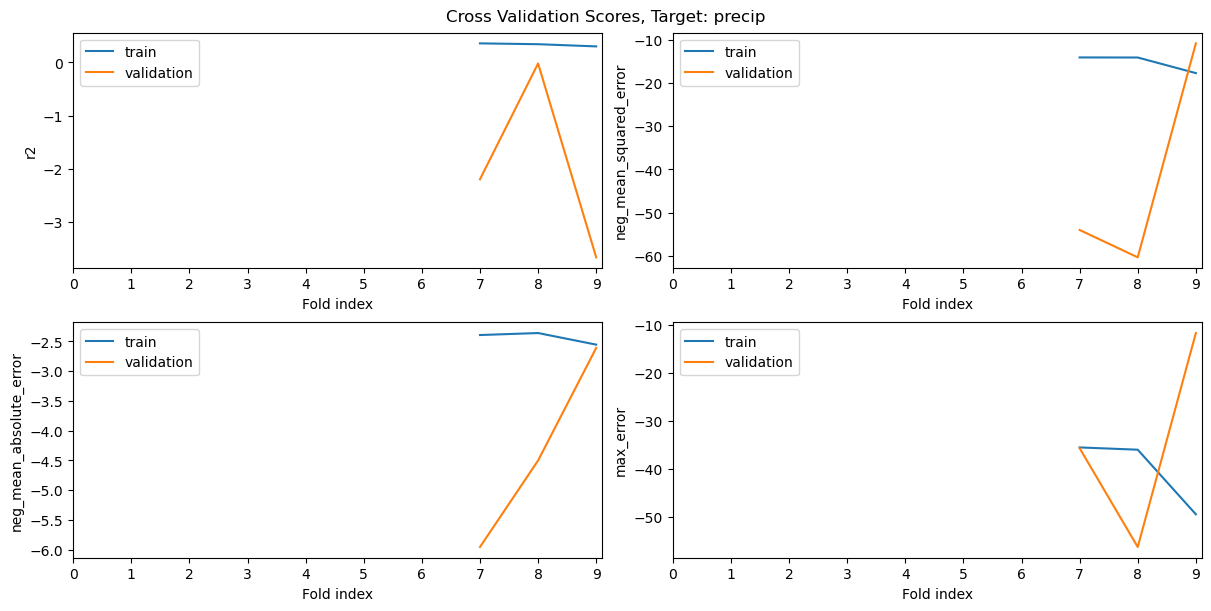

In [224]:
plot_score_cv(cv_results_precip, target = "precip", skip_folds = 7)

In [225]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 8)

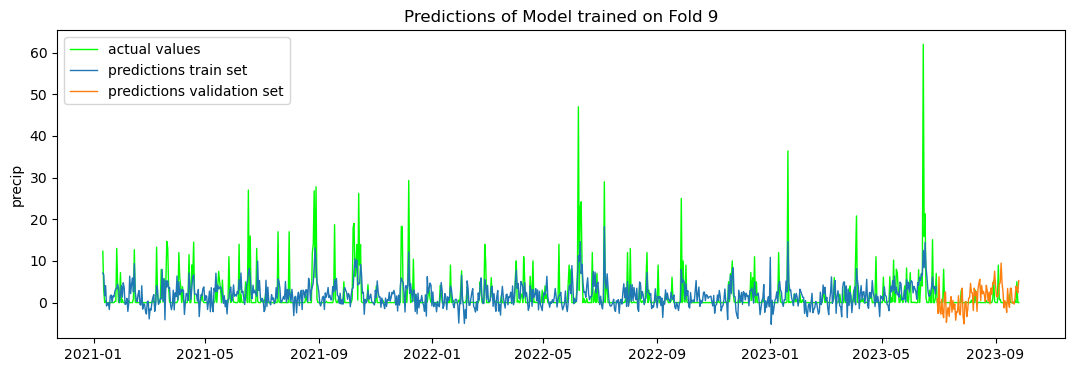

In [226]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 9)

And model on cloudcover:

In [227]:
cv_results_cloudcover = run_cv_experiment(
    pipe_linear_all_features, 
    weather_data_with_lags, 
    weather_data_with_lags.cloudcover,
    time_series_cv, 
    experiment_name = "linear_all_features", 
    target_name = "cloudcover",
    
    log_experiment = False
) 

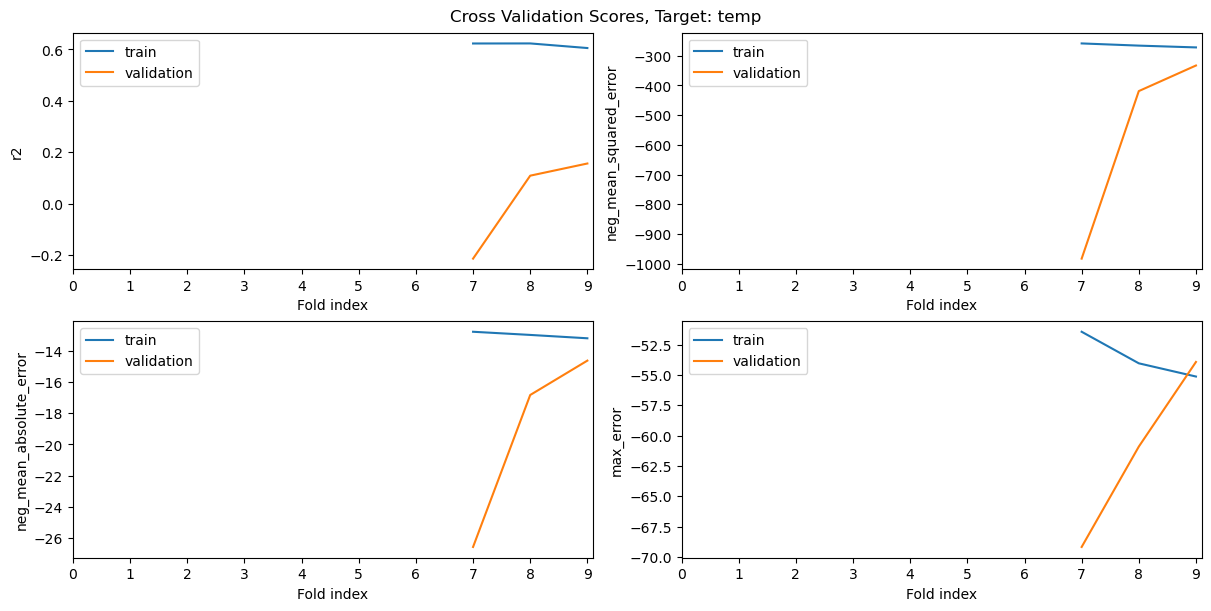

In [230]:
plot_score_cv(cv_results_cloudcover, skip_folds = 7)

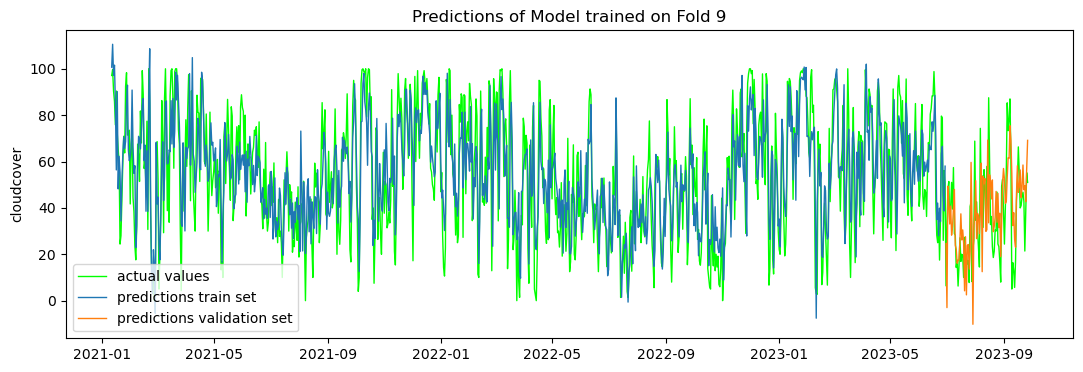

In [231]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 9)

Exploding gradients on the first few folds make us look into dimensionality reduction - we have over 200 features with less than 1000 observations and we don't even use them all for training. Bad results on the last two folds however suggest that reducing the dimensions alone will lead to even worse results. 
We will add non-linearity to our model with polynomial features and than perform PCA with the hope that it will allow us to improve the results. Linear PCA is tried only as exploration of the dataset (we know that we have correlated variables, a lot of), we do not expect good results from model with it.

In [238]:
pipe_pca = Pipeline(
    steps=[
        ("preprocess", preprozess_all_features),
        ("pca", PCA())
    ]
)

In [239]:
pca = pipe_pca.fit(weather_data_with_lags)

In [240]:
pca.n_features_in_

238

In [241]:
variance_ratio = np.cumsum(pipe_pca["pca"].explained_variance_ratio_)

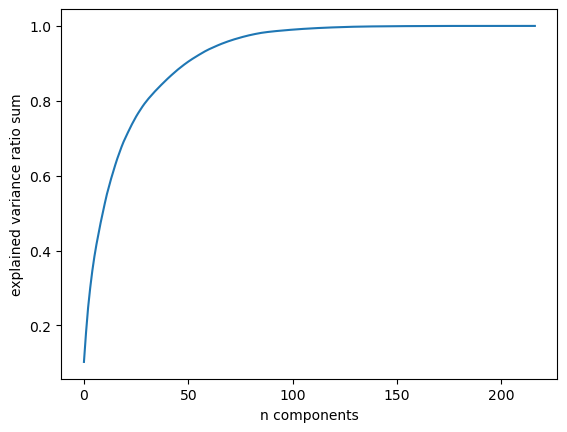

In [242]:
plt.plot(variance_ratio)
plt.xlabel("n components")
plt.ylabel("explained variance ratio sum")
plt.show()

In [243]:
variance_ratio[100]

0.9900905597492474

In [254]:
# pd.DataFrame(pipe_pca["pca"].components_, columns = pipe_pca["preprocess"].get_feature_names_out())

In [741]:
pipe_poly_pca = Pipeline(
    steps=[
        ("preprocess", preprozess_all_features),
        ("polynomials", PolynomialFeatures(degree = 2, interaction_only = False)),
        ("pca", PCA())
    ]
)

In [742]:
poly_pca = pipe_poly_pca.fit(weather_data_with_lags)

In [743]:
poly_pca["pca"].n_features_in_

23220

In [255]:
variance_ratio = np.cumsum(pipe_poly_pca["pca"].explained_variance_ratio_)

NameError: name 'pipe_poly_pca' is not defined

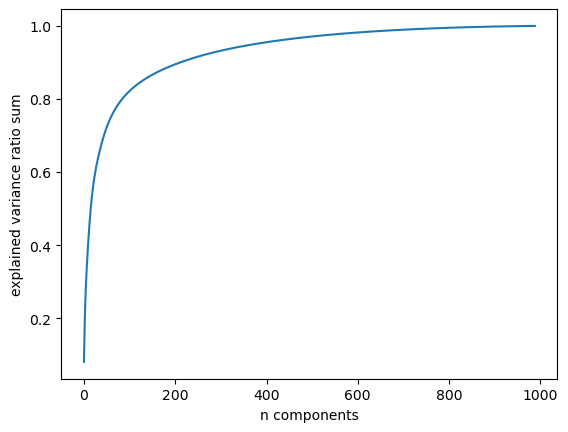

In [ ]:
plt.plot(variance_ratio)
plt.xlabel("n components")
plt.ylabel("explained variance ratio sum")
plt.show()

In [256]:
variance_ratio[600]

IndexError: index 600 is out of bounds for axis 0 with size 217

In [747]:
# pipe_poly_3_pca = Pipeline(  
#     steps=[
#         ("preprocess", preprozess_all_features),
#         ("polynomials", PolynomialFeatures(degree = 3, interaction_only = False)),
#         ("pca", PCA())
#     ]
# )

In [748]:
# pipe_poly_3_pca.fit(weather_data_with_lags) # my 10-year old machine says NO

We evaluate the models, skipping linear PCA, because we know it will perform the same way as the previous regression model and smaller number of components will lead to even more underfitting. Instead of PolynomialFeatures followed by linear PCA, we use polynomial kernel. The results are supposed to be the same and it is much faster, although we will lose the opportunity to explore the polynomials and explained variance of PCA. We can also try __Radial Basis Function Kernel__ (RBF or Gaussian).

In [259]:
# model_pca = Pipeline(
#     steps=[
#         ("preprocess", preprozess_all_features),
#         ("pca", PCA(n_components = None)),
#         ("model", LinearRegression())
#     ]
# )

In [260]:
model_pca_poly = Pipeline(
    steps=[
        ("preprocess", preprozess_all_features),
        ("pca", KernelPCA(n_components = None, kernel = "poly", degree = 2)),
        ("model", LinearRegression())
    ]
)

In [261]:
model_pca_rbf = Pipeline(
    steps=[
        ("preprocess", preprozess_all_features),
        ("pca", KernelPCA(n_components = None, kernel = "rbf", gamma = None)),
        ("model", LinearRegression())
    ]
)

Run and log experiment with linear model with PCA with polynomial kernel of 2 degree.

In [262]:
cv_results_temp = run_cv_experiment(
    model_pca_poly, 
    weather_data_with_lags, 
    weather_data_with_lags.temp, 
    cv = time_series_cv,
    experiment_name = "model_pca_poly",

    log_experiment = False
)

In [263]:
plot_score_cv(cv_results_temp, skip_folds = 0)

At last, our model managed to overfit the data! We're on the right track. Let's see the predictions time series:

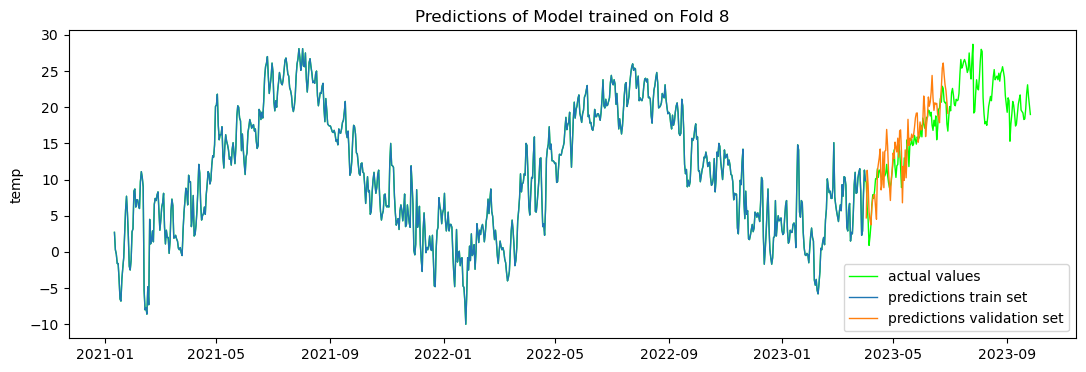

In [264]:
plot_cv_predictions(cv_results_temp, weather_data_with_lags, "temp", n_fold = 8)

In [265]:
plot_cv_predictions(cv_results_temp, weather_data_with_lags, "temp", n_fold = 9)

Textbook overfitting - great performance on training set, poor on validation set. Let's try a same model on precipitation:

In [266]:
cv_results_precip = run_cv_experiment(
    model_pca_poly, 
    weather_data_with_lags, 
    weather_data_with_lags.precip,
    time_series_cv, 
    experiment_name = "model_pca_poly", 
    target_name = "precip",

    log_experiment = False
) 

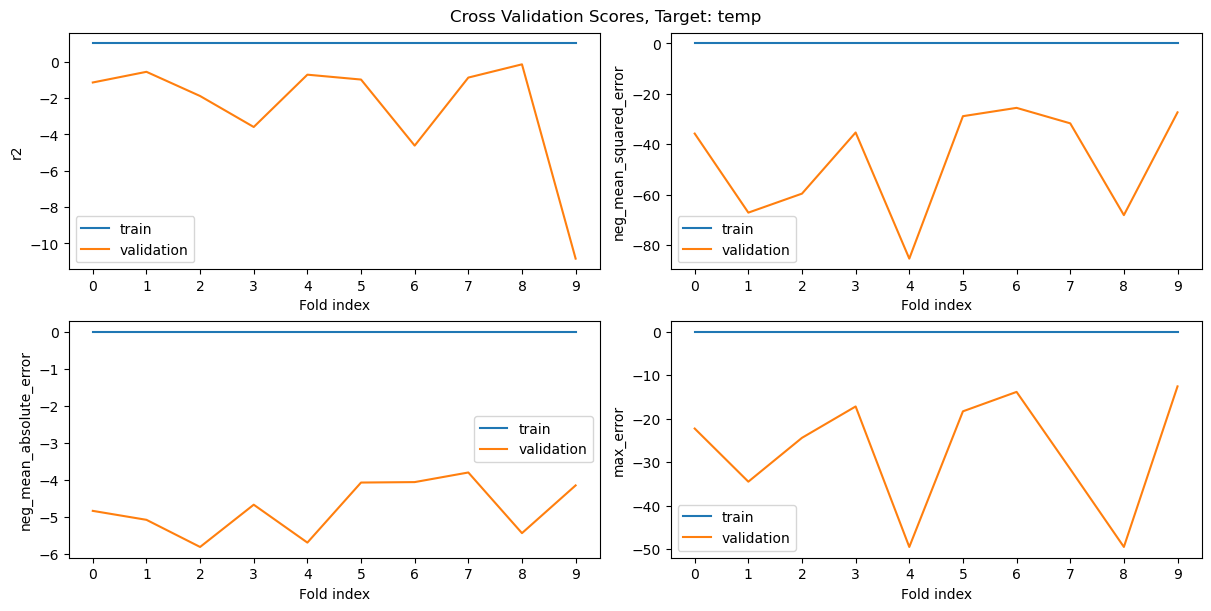

In [267]:
plot_score_cv(cv_results_precip, skip_folds = 0)

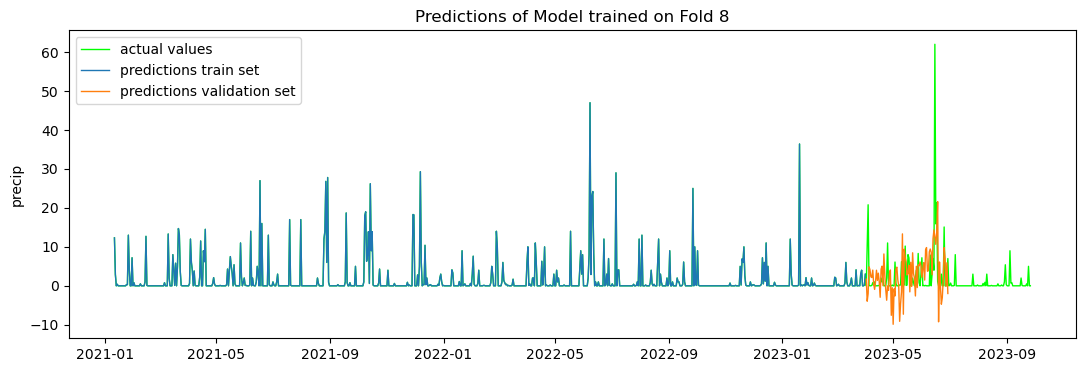

In [268]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 8)

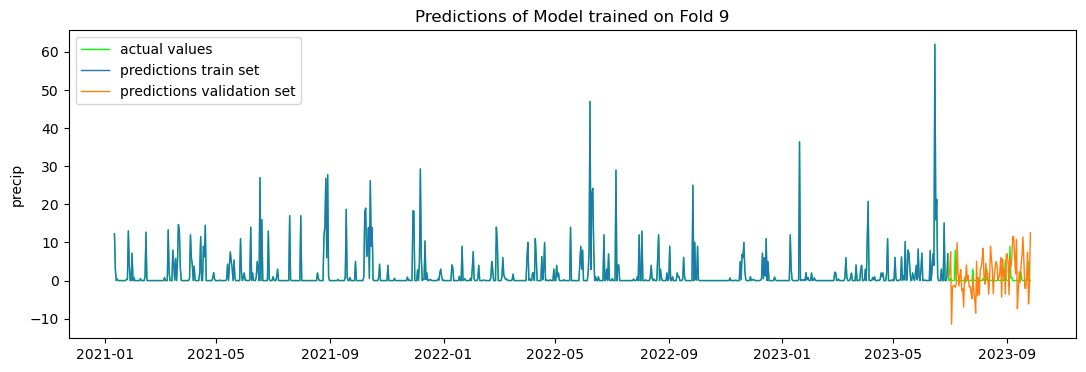

In [269]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 9)

Same verdict here - great on training, very bad on validation. Let's see cloudcover:

In [270]:
cv_results_cloudcover = run_cv_experiment(
    model_pca_poly, 
    weather_data_with_lags, 
    weather_data_with_lags.cloudcover,
    time_series_cv, 
    experiment_name = "model_pca_poly", 
    target_name = "cloudcover",

    log_experiment = False
)

In [271]:
plot_score_cv(cv_results_cloudcover, skip_folds = 1)

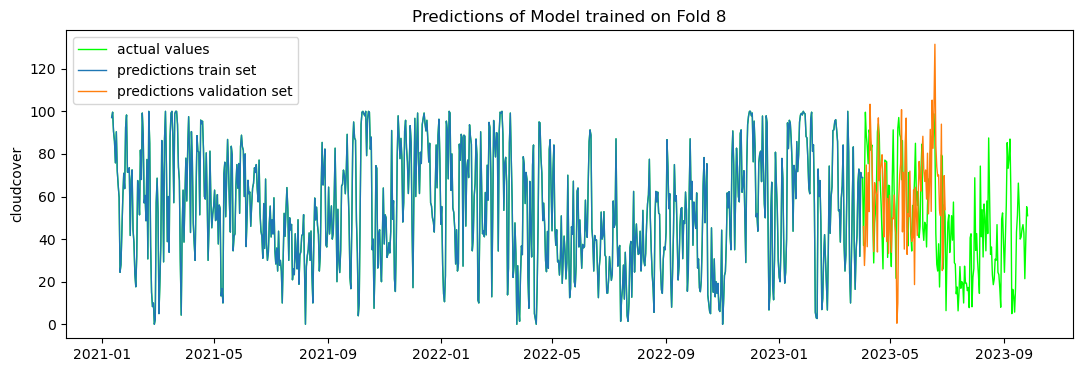

In [272]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 8)

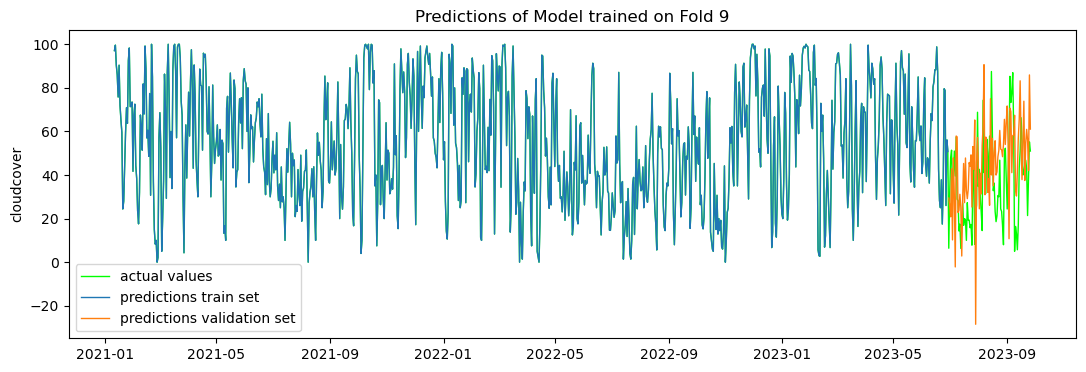

In [273]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 9)

The models on all three targets with polynomial kernel with degree = 2 clearly overfit - they describe the training set very well but preform badly on the validation sets. In order to help them generalize, we need some regularisation. First we lower the number of components of the PCA, and than add actual L2 regularisation with Ridge. L1 after PCA seems unnececcery, as we do not expect any of the new features to have 0 contribution to the model if we constrain the number of principal components.

In order to find the optimal number of components to keep and optimal regularisation coeffitient, we make grid search cv. We are fully aware that our stupid time series split with it's useless first few folds makes the results questionable, but we tried it anyway. Results were huge error on first folds, messing up the mean score and ranking. This is the reason we use only last 5 folds of the time series split for the grid search.

In [ ]:
time_series_indices = [fold_indices for fold_indices in time_series_cv.split(weather_data_with_lags)][5:]
# time_series_indices[0]

In [274]:
ridge_pca_poly = Pipeline(
    steps=[
        ("preprocess", preprozess_all_features),
        ("pca", KernelPCA(degree = 2)),
        ("ridge", Ridge())
    ]
)

In [275]:
param_grid = {
    "pca__n_components": [50, 100, 200, None],
    "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
}

In [276]:
# param_grid = {
#     "pca__kernel": ["poly", "rbf"],
#     "pca__degree": [2, 3, 4],
#     "pca__gamma": [1e-3, 1e-2, 1e-1, 1, 10, 100],
#     "pca__n_components": [100, 200, None],
#     "ridge__alpha": [0.001, 0.01, 1, 10]
# }

After running the experiment with the given parameter grid, we found that best 5 models have the same ranking on all scoring metrics, and all have 200 or none `n_components` and `alpha` of 0.1 or 0.01, so we updated the grid. Then we tried with __rbf__ kernel with different gammas, again polynomial kernel with `degree = 3`. It was hard to choose best model, because many of the combinations of the parameter grid lead to insignificant differences on both r2 and mse scoring (mae and max error were kept more for sanity check, actual evaluation was mainly in r2 and mse). So finally we chose our model following the Occam's Razor principle - from all the models with similar results we have chosen the simplest one - PCA with 2 degree polynomial kernel. (Similar results meaning equally bad :D) This is the final param grid:

In [299]:
param_grid_temp = {
    "pca__kernel": ["poly"],
    "pca__degree": [2],
    "pca__n_components": [160, 170, 180, 190, 200, None],
    "ridge__alpha": [0.04, 0.05, 0.06, 0.07, 0.08]
}

In [280]:
# grid_search = GridSearchCV(
#     ridge_pca_poly, 
#     param_grid = param_grid,
#     cv = time_series_indices[4:],
#     scoring = scoring_metrics,
#     refit = "r2", # choose best model based on r2 only
#     return_train_score = True
# )

In [285]:
# experiment = mlflow.create_experiment(name = "grid_search_temp")
# experiment

'965465466338085016'

In [300]:
grid_search_temp, grid_search_results_temp = run_grid_search(
    ridge_pca_poly,
    weather_data_with_lags,
    weather_data_with_lags.temp,
    param_grid_temp,
    time_series_indices,
    scoring_metrics = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"),
    run_name = "large_f", 
    target = "temp",
    pca_kernel = "poly_2",
    log_run = True,
    experiment = "965465466338085016")

In [304]:
best_params_temp = grid_search_temp.best_params_
best_params_temp

{'pca__degree': 2,
 'pca__kernel': 'poly',
 'pca__n_components': 170,
 'ridge__alpha': 0.05}

In [305]:
filter_grid_search_df(grid_search_results_temp)

5         6         7         8         9
param_pca__degree               2         2         2         2         2
param_pca__kernel            poly      poly      poly      poly      poly
param_pca__n_components       170       170       170       170       170
param_ridge__alpha           0.04      0.05      0.06      0.07      0.08
split0_test_r2           0.789902  0.790165  0.789691  0.788684  0.787286
split1_test_r2           0.720571  0.720188  0.719495  0.718577  0.717498
split2_test_r2           0.568777  0.567093  0.565605  0.564281  0.563091
split3_test_r2           0.806068  0.808289  0.810217  0.811911  0.813411
split4_test_r2           0.626008  0.625691  0.624961  0.623911   0.62261
mean_test_r2             0.702266  0.702285  0.701994  0.701473  0.700779
std_test_r2              0.092114  0.093192  0.094069  0.094797  0.095412
rank_test_r2                    2         1         3         4         5
split0_train_r2          0.958708  0.957805  0.956889  0.955975  0.955073
split1_train_r2          0.959653   0.95897  0.958266  0.957556  0.956847
split2_train_r2          0.954769  0.954132  0.953473  0.952805  0.952135
split3_train_r2          0.949765  0.949146  0.948502  0.947844  0.947183
split4_train_r2          0.947611  0.947048  0.946457  0.945851  0.945237
mean_train_r2            0.954101   0.95342  0.952718  0.952006  0.951295
std_train_r2             0.004763  0.004678  0.004598  0.004526  0.004459

In [306]:
filter_grid_search_df(grid_search_results_temp, metric = "neg_mean_squared_error")

5         6         7         8  \
param_pca__degree                           2         2         2         2   
param_pca__kernel                        poly      poly      poly      poly   
param_pca__n_components                   170       170       170       170   
param_ridge__alpha                       0.04      0.05      0.06      0.07   
split0_test_neg_mean_squared_error  -3.749792 -3.745102 -3.753565 -3.771542   
split1_test_neg_mean_squared_error  -5.648338 -5.656084 -5.670105 -5.688643   
split2_test_neg_mean_squared_error  -8.845078 -8.879627 -8.910143 -8.937312   
split3_test_neg_mean_squared_error  -4.205479 -4.157333  -4.11551 -4.078788   
split4_test_neg_mean_squared_error  -3.237937  -3.24068    -3.247 -3.256092   
mean_test_neg_mean_squared_error    -5.137325 -5.135765 -5.139264 -5.146476   
std_test_neg_mean_squared_error      2.020387  2.038129  2.051839  2.062442   
rank_test_neg_mean_squared_error            2         1         3         4   
split0_train_neg_mean_squared_error -3.060117 -3.126997 -3.194899 -3.262634   
split1_train_neg_mean_squared_error -3.044074 -3.095634 -3.148697 -3.202276   
split2_train_neg_mean_squared_error -3.191773 -3.236705 -3.283194 -3.330363   
split3_train_neg_mean_squared_error -3.482827 -3.525705 -3.570385 -3.615961   
split4_train_neg_mean_squared_error -3.433744  -3.47063 -3.509352 -3.549106   
mean_train_neg_mean_squared_error   -3.242507 -3.291134 -3.341305 -3.392068   
std_train_neg_mean_squared_error     0.184142  0.176276  0.168894  0.162093   

                                            9  
param_pca__degree                           2  
param_pca__kernel                        poly  
param_pca__n_components                   170  
param_ridge__alpha                       0.08  
split0_test_neg_mean_squared_error  -3.796482  
split1_test_neg_mean_squared_error  -5.710455  
split2_test_neg_mean_squared_error  -8.961714  
split3_test_neg_mean_squared_error  -4.046255  
split4_test_neg_mean_squared_error   -3.26736  
mean_test_neg_mean_squared_error    -5.156453  
std_test_neg_mean_squared_error      2.070636  
rank_test_neg_mean_squared_error            5  
split0_train_neg_mean_squared_error -3.329498  
split1_train_neg_mean_squared_error -3.255748  
split2_train_neg_mean_squared_error -3.377651  
split3_train_neg_mean_squared_error -3.661834  
split4_train_neg_mean_squared_error -3.589349  
mean_train_neg_mean_squared_error   -3.442816  
std_train_neg_mean_squared_error     0.155899

In [308]:
filter_grid_search_df(grid_search_results_temp, metric = "neg_mean_absolute_error")

5         6         7         8  \
param_pca__degree                            2         2         2         2   
param_pca__kernel                         poly      poly      poly      poly   
param_pca__n_components                    170       170       170       170   
param_ridge__alpha                        0.04      0.05      0.06      0.07   
split0_test_neg_mean_absolute_error  -1.497916 -1.510888 -1.522985 -1.534294   
split1_test_neg_mean_absolute_error  -1.904957 -1.907945  -1.91124  -1.91432   
split2_test_neg_mean_absolute_error   -2.24746 -2.246431 -2.247427 -2.247619   
split3_test_neg_mean_absolute_error  -1.650435 -1.639732 -1.629317  -1.61919   
split4_test_neg_mean_absolute_error  -1.382642 -1.378242  -1.37501 -1.374281   
mean_test_neg_mean_absolute_error    -1.736682 -1.736648 -1.737196 -1.737941   
std_test_neg_mean_absolute_error      0.309517  0.309204  0.309622   0.30942   
rank_test_neg_mean_absolute_error            2         1         3         4   
split0_train_neg_mean_absolute_error -1.327397 -1.339482 -1.353209 -1.367424   
split1_train_neg_mean_absolute_error -1.324143  -1.33182 -1.341216 -1.351829   
split2_train_neg_mean_absolute_error  -1.37009 -1.377688 -1.386302 -1.395659   
split3_train_neg_mean_absolute_error  -1.42142 -1.428373 -1.436322 -1.444511   
split4_train_neg_mean_absolute_error  -1.40767 -1.414182 -1.421572 -1.429459   
mean_train_neg_mean_absolute_error   -1.370144 -1.378309 -1.387724 -1.397776   
std_train_neg_mean_absolute_error     0.039952  0.038633  0.037051  0.035284   

                                             9  
param_pca__degree                            2  
param_pca__kernel                         poly  
param_pca__n_components                    170  
param_ridge__alpha                        0.08  
split0_test_neg_mean_absolute_error    -1.5461  
split1_test_neg_mean_absolute_error  -1.917221  
split2_test_neg_mean_absolute_error   -2.24745  
split3_test_neg_mean_absolute_error  -1.609345  
split4_test_neg_mean_absolute_error   -1.37549  
mean_test_neg_mean_absolute_error    -1.739121  
std_test_neg_mean_absolute_error      0.308689  
rank_test_neg_mean_absolute_error            5  
split0_train_neg_mean_absolute_error  -1.38197  
split1_train_neg_mean_absolute_error -1.362518  
split2_train_neg_mean_absolute_error -1.405108  
split3_train_neg_mean_absolute_error -1.453314  
split4_train_neg_mean_absolute_error -1.437284  
mean_train_neg_mean_absolute_error   -1.408039  
std_train_neg_mean_absolute_error     0.033661

With the grid search best estimator we run an experiment. We know we have all the data in `grid_search.cv_results_`, but it's easier to use our function for logging and visualization.


In [309]:
cv_results_temp = run_cv_experiment(
    grid_search_temp.best_estimator_, 
    weather_data_with_lags, 
    weather_data_with_lags.temp, 
    cv = time_series_cv,
    experiment_name = "grid_search_final_",
    target_name = "temp",

    log_experiment = True
)

In [310]:
plot_score_cv(cv_results_temp, skip_folds = 5)

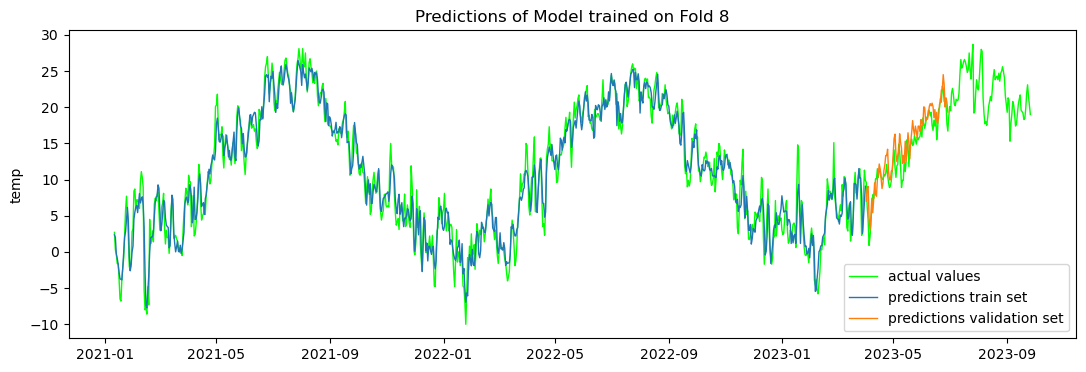

In [311]:
plot_cv_predictions(cv_results_temp, weather_data_with_lags, "temp", n_fold = 8)

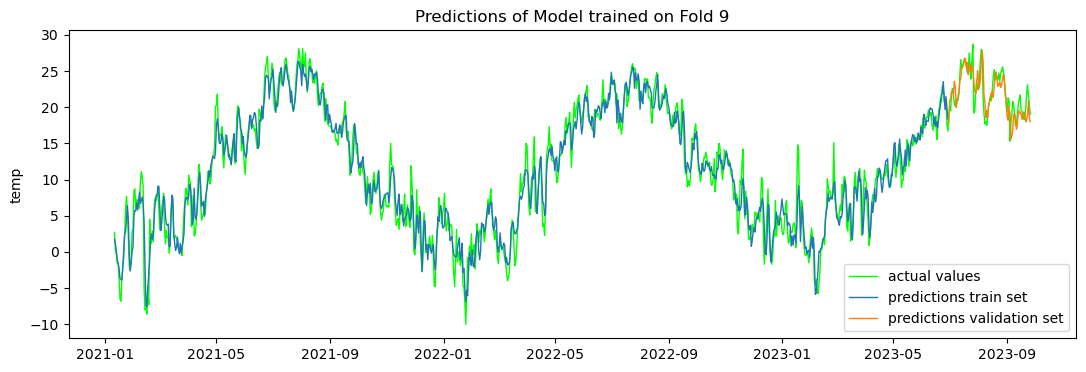

In [312]:
plot_cv_predictions(cv_results_temp, weather_data_with_lags, "temp", n_fold = 9)

After several iterations these are the final grid search parameters for percipitation:

In [387]:
param_grid_precip = {
    "pca__kernel": ["poly"],
    "pca__degree": [2],
    "pca__n_components": [180, 190, 200, None],
}

In [388]:
# experiment = mlflow.create_experiment(name = "grid_search_precip")
# experiment

In [391]:
grid_search_precip, grid_search_results_precip = run_grid_search(
    model_pca_poly,
    weather_data_with_lags,
    weather_data_with_lags.precip,
    param_grid_precip,
    time_series_indices,
    scoring_metrics = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"),
    run_name = "lin_reg", 
    target = "precip",
    pca_kernel = "poly",
    log_run = True,
    experiment = "519245658093025969")

In [392]:
grid_search_precip.best_params_

{'pca__degree': 2, 'pca__kernel': 'poly', 'pca__n_components': 180}

In [393]:
filter_grid_search_df(grid_search_results_precip, metric = "r2")

0         1         2          3
param_pca__degree               2         2         2          2
param_pca__kernel            poly      poly      poly       poly
param_pca__n_components       180       190       200       None
split0_test_r2          -0.346385 -0.389698 -0.397718  -0.986452
split1_test_r2            -0.8236 -0.903822 -0.916686  -4.620011
split2_test_r2          -0.254441 -0.278369  -0.26909  -0.878143
split3_test_r2           0.071281  0.067506  0.069932  -0.149669
split4_test_r2          -2.668519 -2.664269 -2.656762 -10.835274
mean_test_r2            -0.804333  -0.83373 -0.834065   -3.49391
std_test_r2              0.975127   0.96681  0.964972    3.98691
rank_test_r2                    1         2         3          4
split0_train_r2          0.391219  0.414223  0.431746        1.0
split1_train_r2          0.346878  0.355657  0.370022        1.0
split2_train_r2          0.329716  0.341924  0.349235        1.0
split3_train_r2          0.315568  0.325115   0.33617        1.0
split4_train_r2          0.295604   0.30031  0.307776        1.0
mean_train_r2            0.335797  0.347446   0.35899        1.0
std_train_r2             0.032422  0.038151  0.041602        0.0

In [394]:
filter_grid_search_df(grid_search_results_precip, metric = "neg_mean_squared_error")

0          1          2  \
param_pca__degree                            2          2          2   
param_pca__kernel                         poly       poly       poly   
param_pca__n_components                    180        190        200   
split0_test_neg_mean_squared_error  -19.566684 -20.196138 -20.312698   
split1_test_neg_mean_squared_error   -8.297062  -8.662058  -8.720583   
split2_test_neg_mean_squared_error  -21.179035  -21.58301 -21.426359   
split3_test_neg_mean_squared_error   -55.03984 -55.263565 -55.119773   
split4_test_neg_mean_squared_error   -8.476776  -8.466955  -8.449609   
mean_test_neg_mean_squared_error    -22.511879 -22.834345 -22.805804   
std_test_neg_mean_squared_error      17.132216  17.131584  17.069299   
rank_test_neg_mean_squared_error             1          3          2   
split0_train_neg_mean_squared_error -15.691803 -15.098862 -14.647198   
split1_train_neg_mean_squared_error  -15.82512 -15.612392 -15.264336   
split2_train_neg_mean_squared_error -14.710444 -14.442534 -14.282072   
split3_train_neg_mean_squared_error -14.679146 -14.474378 -14.237273   
split4_train_neg_mean_squared_error -17.863143 -17.743808 -17.554466   
mean_train_neg_mean_squared_error   -15.753931 -15.474395 -15.197069   
std_train_neg_mean_squared_error      1.157733   1.214502   1.234717   

                                             3  
param_pca__degree                            2  
param_pca__kernel                         poly  
param_pca__n_components                   None  
split0_test_neg_mean_squared_error  -28.868623  
split1_test_neg_mean_squared_error  -25.570064  
split2_test_neg_mean_squared_error  -31.709153  
split3_test_neg_mean_squared_error  -68.134289  
split4_test_neg_mean_squared_error  -27.347536  
mean_test_neg_mean_squared_error    -36.325933  
std_test_neg_mean_squared_error      16.031207  
rank_test_neg_mean_squared_error             4  
split0_train_neg_mean_squared_error       -0.0  
split1_train_neg_mean_squared_error       -0.0  
split2_train_neg_mean_squared_error       -0.0  
split3_train_neg_mean_squared_error       -0.0  
split4_train_neg_mean_squared_error       -0.0  
mean_train_neg_mean_squared_error         -0.0  
std_train_neg_mean_squared_error           0.0

In [359]:
cv_results_precip = run_cv_experiment(
    grid_search_precip.best_estimator_, 
    weather_data_with_lags, 
    weather_data_with_lags.precip, 
    cv = time_series_cv,
    experiment_name = "gridsearch_final",
    target_name = "precip",

    log_experiment = False
)

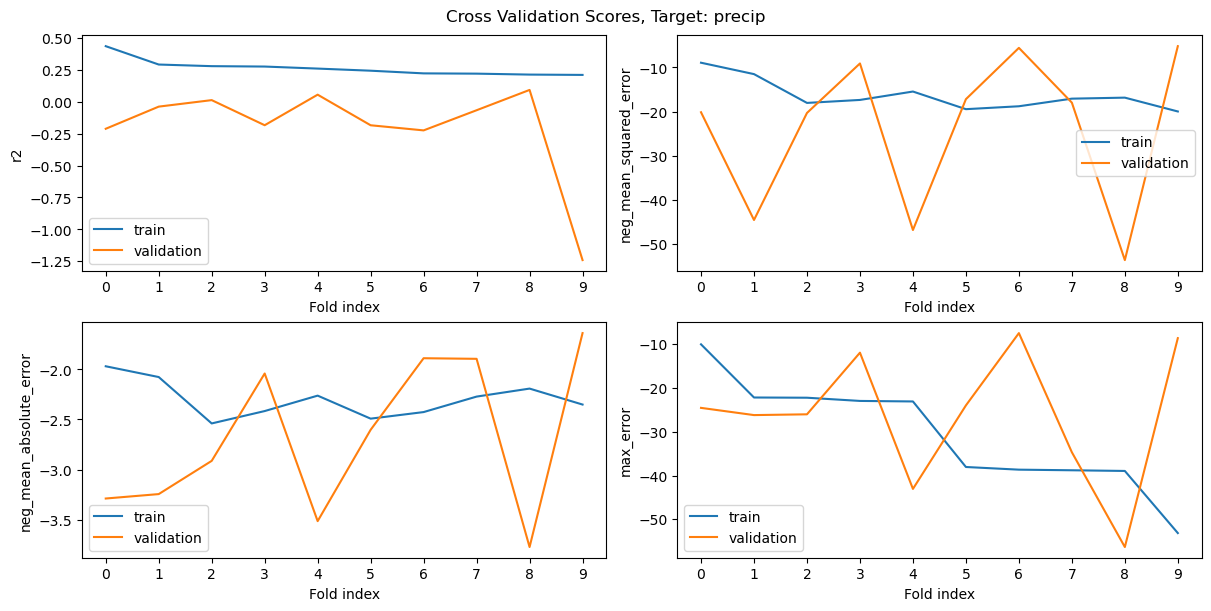

In [360]:
plot_score_cv(cv_results_precip, target = "precip")

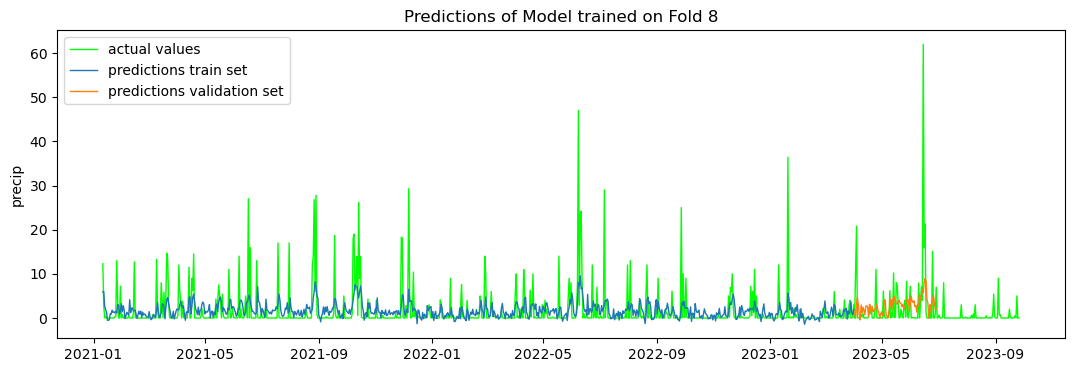

In [361]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 8)

In [362]:
plot_cv_predictions(cv_results_precip, weather_data_with_lags, "precip", n_fold = 9)

And final param grid for cloudcover:

In [373]:
param_grid_cloudcover = {
    "pca__kernel": ["poly"],
    "pca__degree": [2],
    "pca__n_components": [160, 200, None],
    "ridge__alpha": [0.02, 0.04, 1, 4]
}

In [374]:
# experiment = mlflow.create_experiment(name = "grid_search_cloudcover")
# experiment

In [375]:
grid_search_cloudcover, grid_search_results_cloudcover = run_grid_search(
    ridge_pca_poly,
    weather_data_with_lags,
    weather_data_with_lags.cloudcover,
    param_grid_cloudcover,
    time_series_indices,
    scoring_metrics = ("r2", "neg_mean_squared_error", "neg_mean_absolute_error", "max_error"),
    run_name = "gridsearch_final_", 
    target = "cloudcover",
    pca_kernel = "mix",
    log_run = True,
    experiment = "731912940929081393")

In [376]:
grid_search_cloudcover.best_params_

{'pca__degree': 2,
 'pca__kernel': 'poly',
 'pca__n_components': 160,
 'ridge__alpha': 0.04}

In [377]:
filter_grid_search_df(grid_search_results_cloudcover, metric = "r2")

0         1         2         6         10
param_pca__degree               2         2         2         2         2
param_pca__kernel            poly      poly      poly      poly      poly
param_pca__n_components       160       160       160       200      None
param_ridge__alpha           0.02      0.04         1         1         1
split0_test_r2           0.249509  0.273199  0.289339  0.287345  0.288773
split1_test_r2           0.359747  0.363675    0.3365  0.337384  0.335483
split2_test_r2           0.374486  0.382336  0.341134     0.344  0.340207
split3_test_r2           0.281637    0.2875  0.256721  0.255992  0.253228
split4_test_r2           0.117142  0.129922  0.169395  0.170932  0.172016
mean_test_r2             0.276504  0.287326  0.278617  0.279131  0.277942
std_test_r2              0.092392  0.089254  0.062901  0.063105  0.061865
rank_test_r2                    5         1         3         2         4
split0_train_r2          0.622065  0.613466   0.43681   0.44109  0.451076
split1_train_r2           0.61084  0.604815  0.457801  0.461569  0.472172
split2_train_r2          0.597165  0.592137  0.464161  0.467746  0.478831
split3_train_r2           0.58523   0.58186  0.472855  0.476828  0.488847
split4_train_r2          0.573911  0.571019  0.469379  0.473646  0.485448
mean_train_r2            0.597842  0.592659  0.460201  0.464176  0.475275
std_train_r2             0.017251   0.01527  0.012751  0.012667  0.013383

In [378]:
filter_grid_search_df(grid_search_results_cloudcover, metric = "neg_mean_squared_error")

0           1           2  \
param_pca__degree                             2           2           2   
param_pca__kernel                          poly        poly        poly   
param_pca__n_components                     160         160         160   
param_ridge__alpha                         0.02        0.04           1   
split0_test_neg_mean_squared_error  -298.515583 -289.092687 -282.672692   
split1_test_neg_mean_squared_error   -563.84509 -560.386179 -584.318607   
split2_test_neg_mean_squared_error  -506.193382 -499.840421 -533.183648   
split3_test_neg_mean_squared_error  -337.824626 -335.067592 -349.542127   
split4_test_neg_mean_squared_error  -348.522866 -343.477904 -327.895346   
mean_test_neg_mean_squared_error    -410.980309 -405.572956 -415.522484   
std_test_neg_mean_squared_error      104.244109  105.117024  120.014391   
rank_test_neg_mean_squared_error              3           1           5   
split0_train_neg_mean_squared_error -252.619172 -258.366935 -376.447357   
split1_train_neg_mean_squared_error -256.391008 -260.360971 -357.217969   
split2_train_neg_mean_squared_error -276.696787 -280.150296 -368.053338   
split3_train_neg_mean_squared_error -293.190029  -295.57219 -372.625139   
split4_train_neg_mean_squared_error -293.995966 -295.991258 -366.121422   
mean_train_neg_mean_squared_error   -274.578592  -278.08833 -368.093045   
std_train_neg_mean_squared_error      17.555119   16.331838    6.519058   

                                              5           6  
param_pca__degree                             2           2  
param_pca__kernel                          poly        poly  
param_pca__n_components                     200         200  
param_ridge__alpha                         0.04           1  
split0_test_neg_mean_squared_error  -315.741699 -283.465941  
split1_test_neg_mean_squared_error   -555.34667 -583.539865  
split2_test_neg_mean_squared_error  -496.502464 -530.863777  
split3_test_neg_mean_squared_error  -343.926612  -349.88469  
split4_test_neg_mean_squared_error  -338.862957 -327.288417  
mean_test_neg_mean_squared_error     -410.07608 -415.008538  
std_test_neg_mean_squared_error        96.87012  119.217981  
rank_test_neg_mean_squared_error              2           4  
split0_train_neg_mean_squared_error -232.987677 -373.586499  
split1_train_neg_mean_squared_error -239.389559 -354.735885  
split2_train_neg_mean_squared_error -260.828757 -365.590887  
split3_train_neg_mean_squared_error -275.519912 -369.816367  
split4_train_neg_mean_squared_error -276.011462 -363.177152  
mean_train_neg_mean_squared_error   -256.947474 -365.381358  
std_train_neg_mean_squared_error      17.920869    6.406593

In [380]:
cv_results_cloudcover = run_cv_experiment(
    grid_search_cloudcover.best_estimator_, 
    weather_data_with_lags, 
    weather_data_with_lags.cloudcover, 
    cv = time_series_cv,
    experiment_name = "gridsearch_final",
    target_name = "cloudcover",

    log_experiment = False
)

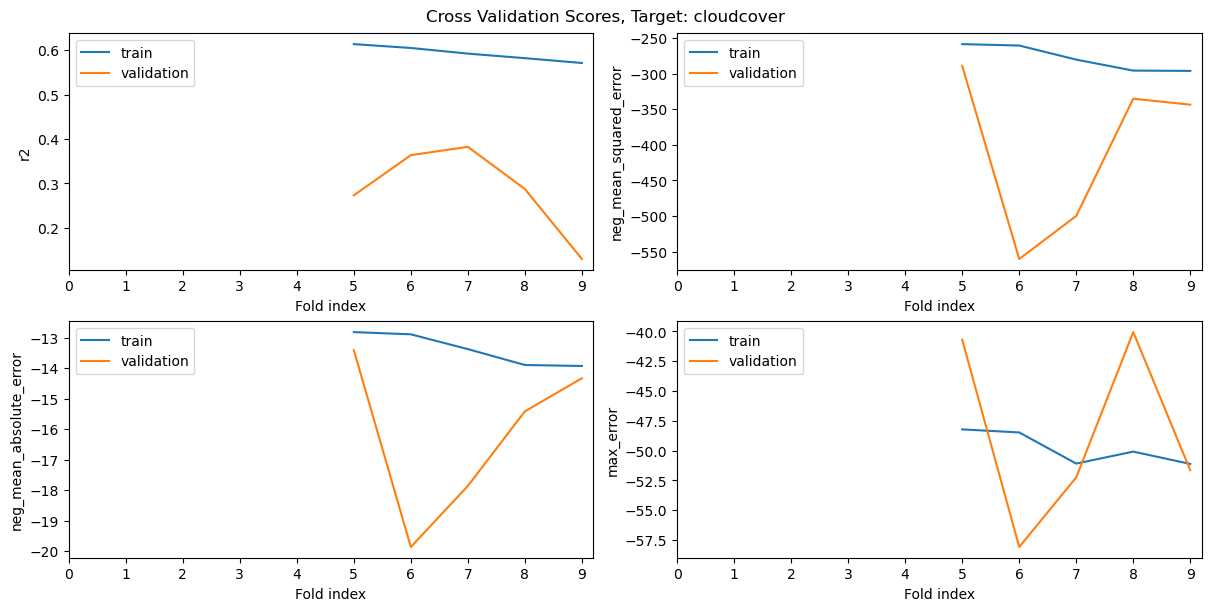

In [382]:
plot_score_cv(cv_results_cloudcover, target = "cloudcover", skip_folds = 5)

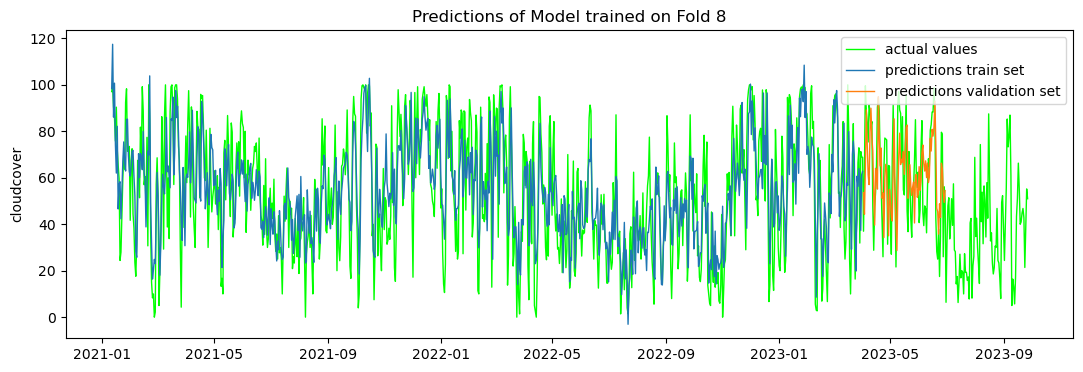

In [385]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 8)

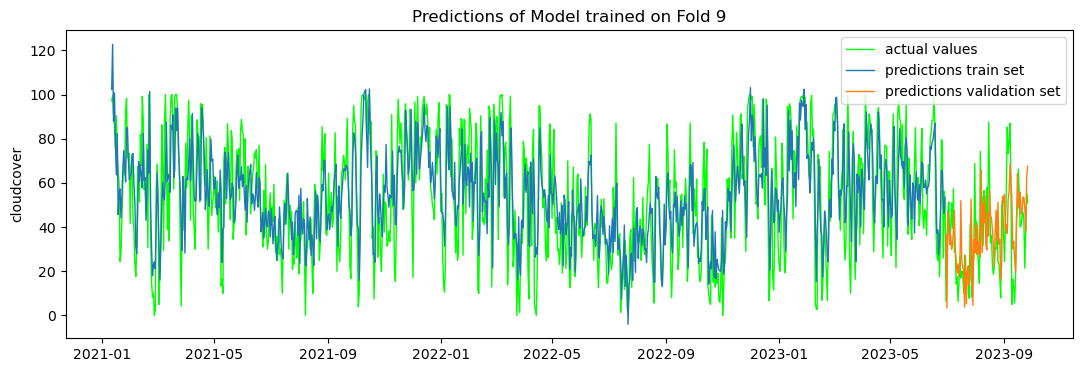

In [386]:
plot_cv_predictions(cv_results_cloudcover, weather_data_with_lags, "cloudcover", n_fold = 9)

Results for precip and cloudcover are flat out disasterous, so we skip gave up on trying to find acceptable param grid. Wrap this up and evaluate the final model.

## 4. Final model

In [395]:
best_model_temp = grid_search_temp.best_estimator_
best_model_precip = grid_search_precip.best_estimator_
best_model_cloudcover = grid_search_cloudcover.best_estimator_

We try to preserve our fitted best estimators:

In [396]:
# from joblib import dump, load


# dump(best_model, 'final_model_precip.joblib')

# PicklingError: Can't pickle <function sin_transformer.<locals>.<lambda> at 0x0000026114653CE0>: it's not found as __main__.sin_transformer.<locals>.<lambda>


And we get an error, probably because of a lambda function. But there is no way I'm editing a function 700 cells above.
Creating lags was left outside the pipeline (because i'm an idiot), so no need to pickle anything anyway...
Which also means we need to evaluate the models here in this notebook.

Read the test dataset:

In [398]:
weather_data_test_raw = pd.read_csv("data/Sofia 2021-01-01 to 2023-09-26.csv")

Do all the preprocessing, that should have been inside the pipeline

In [399]:
weather_data_test_raw["precip"] = weather_data_test_raw["precip"].fillna(0)
weather_data_test_raw["preciptype"] = weather_data_test_raw["preciptype"].fillna("None")

In [409]:
# why is this not in the pipeline, why?!

lags_test = create_lags(weather_data_test_raw, features_with_lag, n_lags)
weather_data_test = pd.concat([weather_data_test_raw, lags_test], axis = 1)
weather_data_test = weather_data_test.drop(range(n_lags))
weather_data_test = weather_data_test.reset_index()
weather_data_test.datetime = pd.to_datetime(weather_data_test.datetime)
weather_data_test["dt_year"] = weather_data_test.datetime.dt.year  
weather_data_test["dt_month"] = weather_data_test.datetime.dt.month 
weather_data_test["dt_week_of_year"] = weather_data_test.datetime.dt.isocalendar().week 
weather_data_test["dt_day_of_year"] = weather_data_test.datetime.dt.day_of_year
weather_data_test.head(3)

index   name   datetime  tempmax  tempmin  temp  feelslikemax  \
0     10  Sofia 2021-01-11      5.1      1.1   2.7           3.4   
1     11  Sofia 2021-01-12      1.1     -0.9   0.3           1.1   
2     12  Sofia 2021-01-13      1.2     -1.3  -0.3          -0.9   

   feelslikemin  feelslike  dew  ...  sealevelpressure_10  cloudcover_10  \
0          -2.1        0.3  1.8  ...               1014.9           32.4   
1          -6.8       -2.0 -0.4  ...               1021.1            8.3   
2          -7.0       -4.7 -3.0  ...               1018.3           75.2   

   visibility_10                 conditions_10  \
0           12.3  Snow, Rain, Partially cloudy   
1           12.4                         Clear   
2           11.3        Rain, Partially cloudy   

                                      description_10    icon_10  dt_year  \
0  Partly cloudy throughout the day with morning ...       rain     2021   
1               Clear conditions throughout the day.  clear-day     2021   
2  Partly cloudy throughout the day with rain in ...       rain     2021   

   dt_month  dt_week_of_year  dt_day_of_year  
0         1                2              11  
1         1                2              12  
2         1                2              13  

[3 rows x 238 columns]

In [410]:
weather_data_test.reset_index().columns

Index(['level_0', 'index', 'name', 'datetime', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike',
       ...
       'sealevelpressure_10', 'cloudcover_10', 'visibility_10',
       'conditions_10', 'description_10', 'icon_10', 'dt_year', 'dt_month',
       'dt_week_of_year', 'dt_day_of_year'],
      dtype='object', length=239)

In [411]:
weather_data_with_lags.columns

Index(['index', 'name', 'datetime', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew',
       ...
       'sealevelpressure_10', 'cloudcover_10', 'visibility_10',
       'conditions_10', 'description_10', 'icon_10', 'dt_year', 'dt_month',
       'dt_week_of_year', 'dt_day_of_year'],
      dtype='object', length=238)

In [413]:
assert weather_data_test.shape[1] == weather_data_with_lags.shape[1]

In [868]:
# weather_data_test.isna().sum().sum()

14571

In [414]:
predictions_temp = best_model_temp.predict(weather_data_test)

In [415]:
best_model_temp.score(weather_data_test, weather_data_test.temp)

0.892533632705115

In [416]:
def plot_predictions(estimator, input_dataframe, target_column):
    plt.figure(figsize=(13, 4))

    
    plt.plot(input_dataframe.datetime, input_dataframe[target_column], c = "lime", lw = 1, label = "actual values") # y_true
    
    predictions_test = estimator.predict(input_dataframe)
    plt.plot(input_dataframe.datetime, predictions_test, lw = 1, c = "orange", label = "predictions test set")

    plt.title(f"Predictions of Final Model")
    plt.ylabel(target_column)
    plt.legend()

    plt.show()

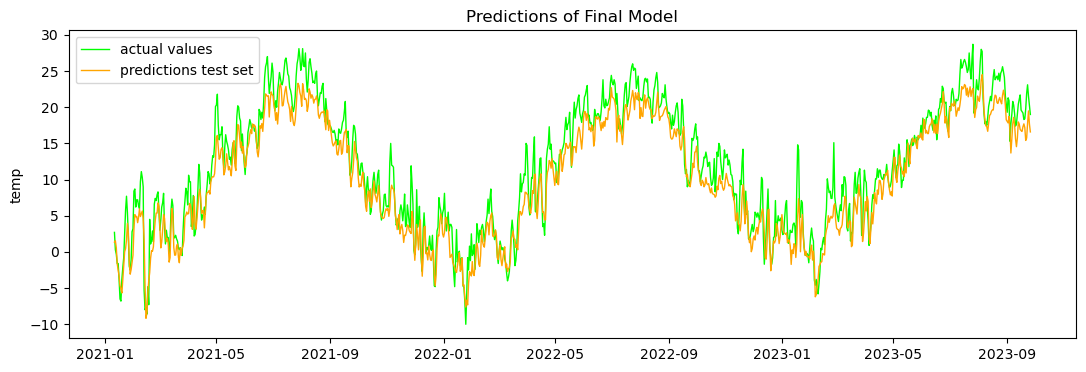

In [417]:
plot_predictions(best_model_temp, weather_data_test, "temp")

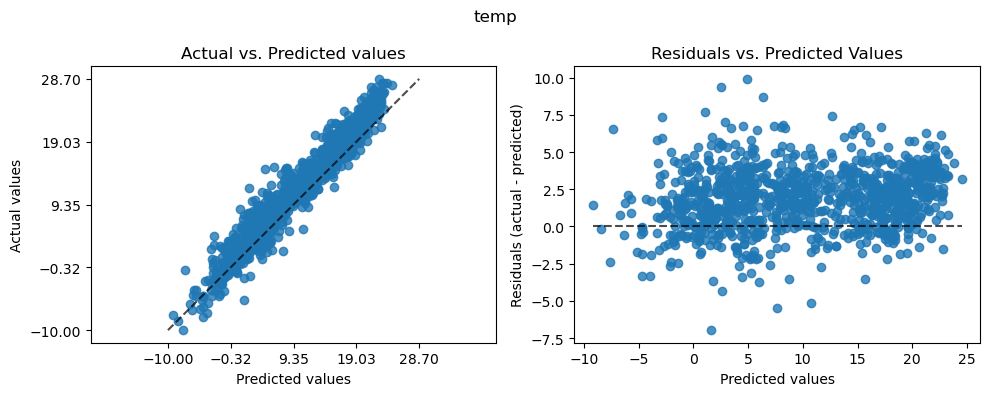

In [423]:
plot_residuals(weather_data_test.temp, predictions_temp, "temp")

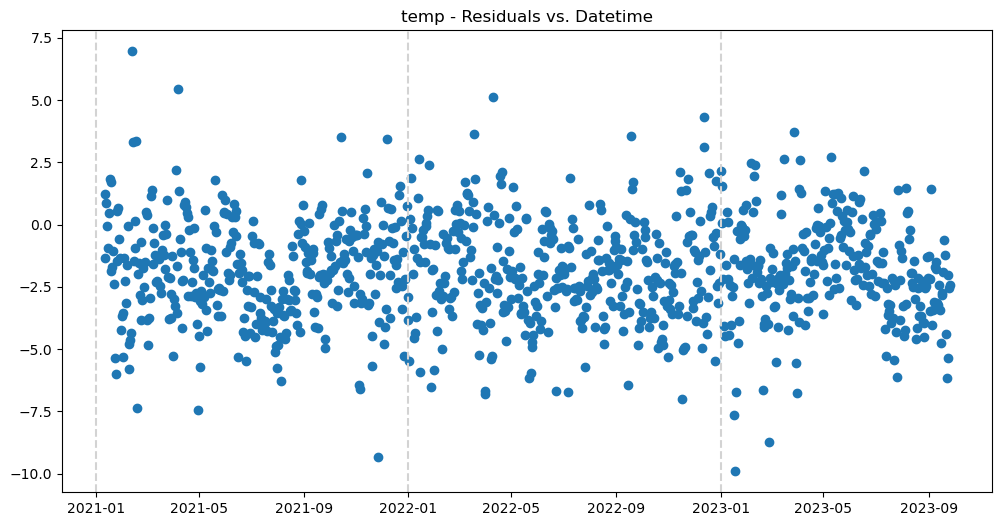

In [424]:
plot_residuals_vs_time(weather_data_test.temp, predictions_temp, "temp", weather_data_test)

I'm sure this will be quite embarassing, but we predict precipitation too:

In [418]:
predictions_precip = best_model_precip.predict(weather_data_test)

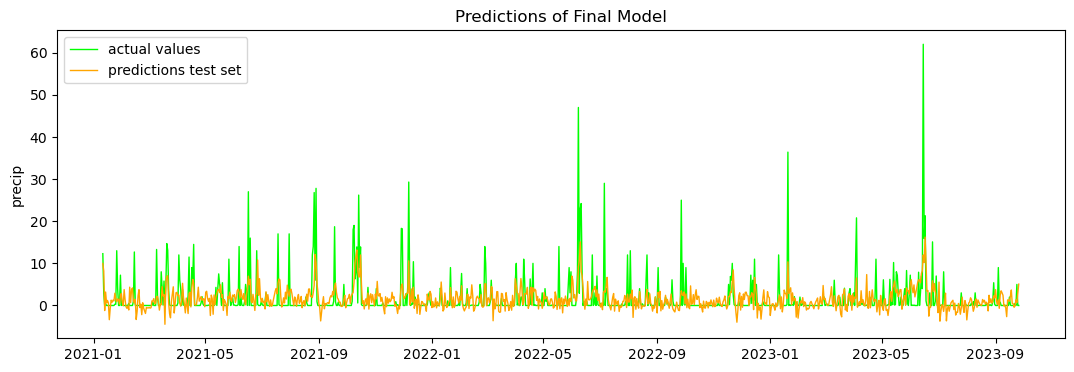

In [421]:
plot_predictions(best_model_precip, weather_data_test, "precip")

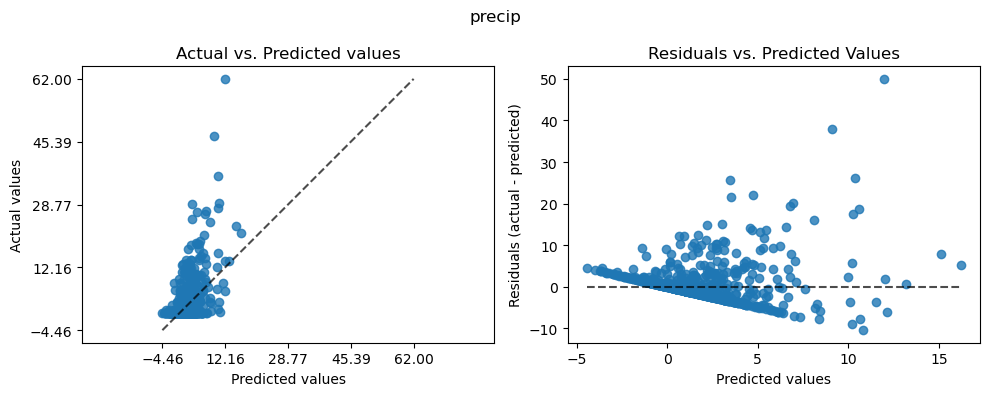

In [425]:
plot_residuals(weather_data_test.precip, predictions_precip, "precip")

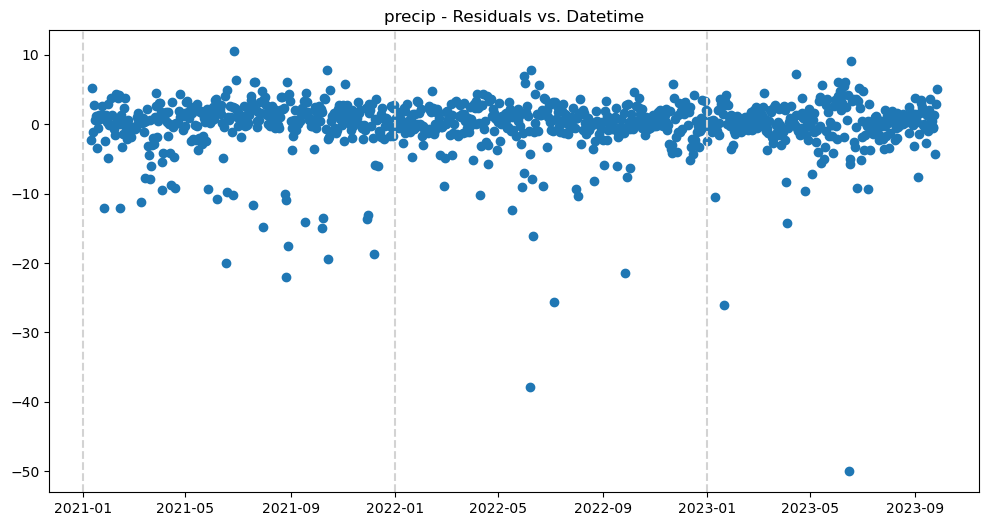

In [426]:
plot_residuals_vs_time(weather_data_test.precip, predictions_precip, "precip", weather_data_test)

And cloudcover:

In [432]:
predictions_cloudcover = best_model_cloudcover.predict(weather_data_test)

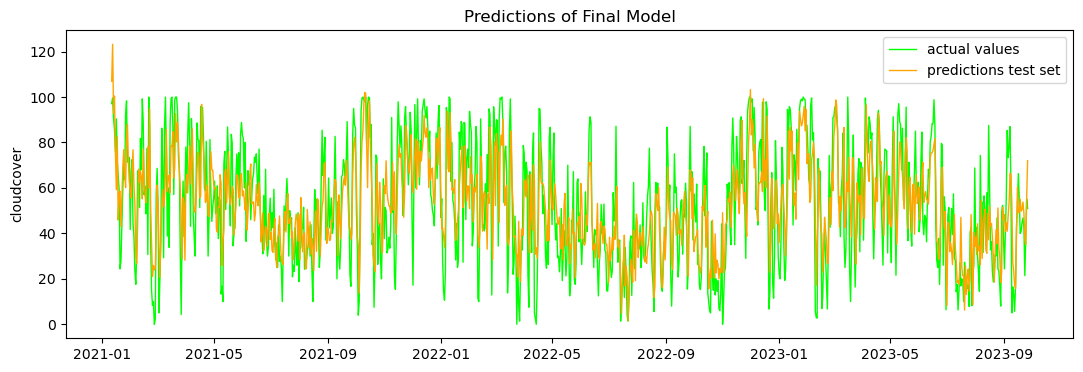

In [436]:
plot_predictions(best_model_cloudcover, weather_data_test, "cloudcover")

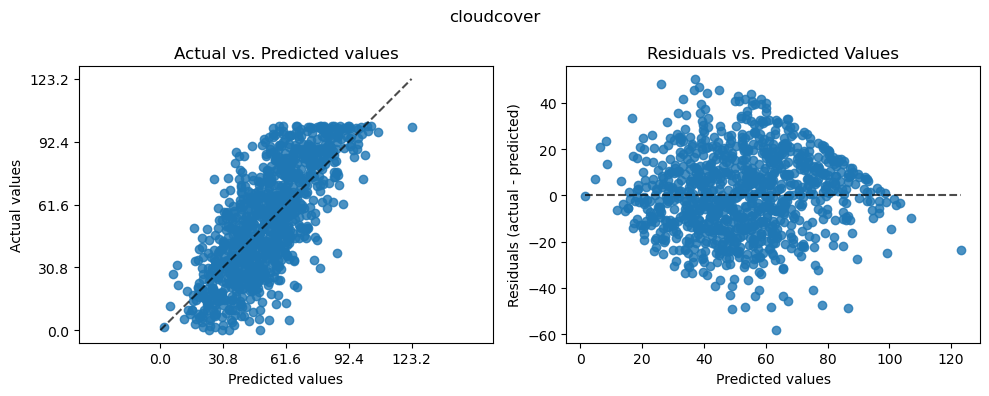

In [437]:
plot_residuals(weather_data_test.cloudcover, predictions_cloudcover, "cloudcover")

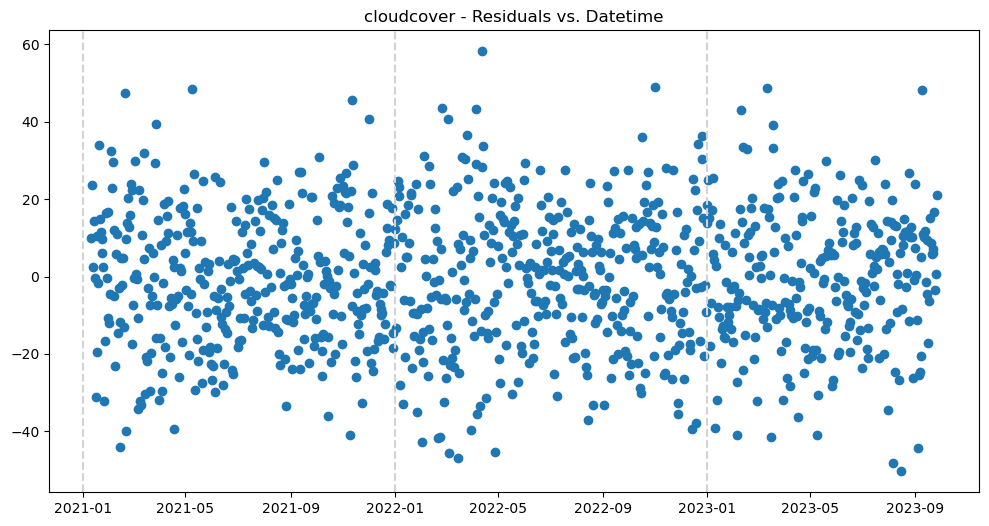

In [438]:
plot_residuals_vs_time(weather_data_test.cloudcover, predictions_cloudcover, "cloudcover", weather_data_test)

Final word on model evaluation - this is single step forecasting, meaning we predict the weather only few hours ahead. If we want to predict the weather 2 or more days ahead we need to predict on our predictions recursively, or train a whole new model for each time step ahead. Our terrible results will become even more terrible, so why bother.

## 5. Conclusion

This work has shown us that huge complex models for weather forecasting are there for a reason. Although our model is unlikely to ever reach performance good enough for real-life applications here are some ways it could be improved:
+ More careful feature engineering:
    - remove or transform correlated features (for example drop `temp`, keep `tempmin` and create `tempdelta` = `tempmax`-`tempmin`) 
    - treat precip as boolean variable - 0 for "no precip" and 1 for any amount
    - find optimal number of lags
+ Better train test and cross validation split - block split or regular k-fold with gaps (with length equal to the number of lags) between test and train data
+ More complex model
    - add more samples (more days with observations)
    - find dataset with samples per hour not per day
    - try svm or some kind of boosting ensemble


And last but not least - put everything in PROPER pipeline.

If you have somehow reached the end of this tedious notebook, thank you for bearing with my clumsy attempts at creating a weather forecasting model with sklearn.
